In [355]:
midx = '66'

# pytorch models with folds

mnames = ['air_u67',
           'preresnet_u67','preresnet_u101',
           'resnet_w65',
           'se_resnext_u29'
           ]

mnames += ['iv3_q11','irv2_q10','resnet_q24','resnet_q25','resnet_q40',
          'gap_q12','nas_q11','se_resnext_q26','se_resnext_q28',
          'bni_q0','bni_q1']

mnames += ['iv3_q12','iv3_u11','iv3_u12','irv2_u12',
           'resnet_q26','resnet_q27',
           'resnet_u25','resnet_u31','resnet_u56','resnet_u60','resnet_u61',
           'resnet_u63','resnet_u65','resnet_u101',
           'se_resnet_u50',
           'gap_u14','bni_u1','bni_u2']

special = 'preresnet_u101'

olist = []

gpct = 90.
gscale = 10.
nfold = 4

In [356]:
import numpy as np
import pandas as pd
import pickle
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Lambda, Activation
from keras.layers import UpSampling2D, Dropout, BatchNormalization, MaxPooling2D
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.applications import MobileNet

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import opening, closing

from scipy.special import logit, expit
import scipy.optimize as opt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import gc
import cv2
from tqdm import tqdm_notebook

from sklearn.metrics import jaccard_similarity_score, f1_score, precision_score, recall_score

# from metrics import iou_metric, iou_metric_batch
# from metric import mean_iou

In [357]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [358]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [359]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [360]:
# train_df["images"] = [np.array(load_img("images/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                       for idx in tqdm_notebook(train_df.index)]

# train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                      for idx in tqdm_notebook(train_df.index)]

In [361]:
df.columns

Index(['Target'], dtype='object')

In [362]:
# estimate thresholds by line search
def F1_hard(preds, targs, th=0.5):
    return -f1_score(targs,  (preds>th).astype(int))

def fit_val1(x, y, start=0.5):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(F1_hard(x,y,p))
    p = opt.minimize_scalar(error, bounds=[0.3,0.7], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [363]:
oof = df.copy()
# print(oof.head())
# print(oof.shape)
eps = 1e-6
num_classes = 28
np.set_printoptions(precision=3,linewidth=80,suppress=True)

for k,m in enumerate(mnames):
    print(' ')
    print(m)
    first = True
    for fold in range(nfold):
        idf, pooff, yooff = pickle.load(open('oof/'+m+'_'+str(fold)+'.pkl','rb'))
        
        # change to probability scale
        # reduce map to single number
        if m in olist: 
            pooff = expit(pooff)
        else: 
            pooff = np.percentile(pooff, gpct, axis=(2,3))
            pooff = 1./(1. + np.exp(-pooff/gscale))
            
        if first:
            id = idf
            poof = pooff.copy()
            yoof = yooff.copy()
            first = False
        else:
            id = id + idf
            poof = np.concatenate((poof,pooff))
            yoof = np.concatenate((yoof,yooff))
    
#     # determine class-specific thresholds and convert predictions to binary
#     th = np.zeros(num_classes)
#     for i in range(num_classes):
#         th[i] = fit_val1(poof[:,i],yoof[:,i])
#     print('Thresholds: ',th)
#     poof = poof > th
#     print('F1 macro: ',f1_score(yoof, poof, average='macro'))

    mdf = pd.DataFrame({'Id':id})
    # print(poof.shape)
    if k==0: mdf['y'] = [yoof[i] for i in range(yoof.shape[0])]
    mdf[m] = [poof[i] for i in range(poof.shape[0])]
    mdf.set_index('Id',inplace=True)
    oof = oof.join(mdf)

 
air_u67
 
preresnet_u67
 
preresnet_u101
 
resnet_w65
 
se_resnext_u29
 
iv3_q11
 
irv2_q10
 
resnet_q24
 
resnet_q25
 
resnet_q40
 
gap_q12
 
nas_q11
 
se_resnext_q26
 
se_resnext_q28
 
bni_q0
 
bni_q1
 
iv3_q12
 
iv3_u11
 
iv3_u12
 
irv2_u12
 
resnet_q26
 
resnet_q27
 
resnet_u25
 
resnet_u31
 
resnet_u56
 
resnet_u60
 
resnet_u61
 
resnet_u63
 
resnet_u65
 
resnet_u101
 
se_resnet_u50
 
gap_u14
 
bni_u1
 
bni_u2


In [364]:
# print(oof.head())
print(oof.shape)

(31072, 36)


In [365]:
oof.columns

Index(['Target', 'y', 'air_u67', 'preresnet_u67', 'preresnet_u101',
       'resnet_w65', 'se_resnext_u29', 'iv3_q11', 'irv2_q10', 'resnet_q24',
       'resnet_q25', 'resnet_q40', 'gap_q12', 'nas_q11', 'se_resnext_q26',
       'se_resnext_q28', 'bni_q0', 'bni_q1', 'iv3_q12', 'iv3_u11', 'iv3_u12',
       'irv2_u12', 'resnet_q26', 'resnet_q27', 'resnet_u25', 'resnet_u31',
       'resnet_u56', 'resnet_u60', 'resnet_u61', 'resnet_u63', 'resnet_u65',
       'resnet_u101', 'se_resnet_u50', 'gap_u14', 'bni_u1', 'bni_u2'],
      dtype='object')

In [366]:
vp = oof.loc[oof['y'].notnull()]
print(vp.shape)

(31072, 36)


In [367]:
# # compute rank transform separately for every column
# from scipy.stats import rankdata
# n = vp.shape[0] * 28
# for m in mnames:
#     a = rankdata(np.array(list(vp[m])).flatten()).reshape((vp.shape[0],28))/n
#     vp[m] = [i for i in a]
# print(vp.shape)

In [368]:
vp.head()

Target  \
Id                                              
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18   

                                                                                      y  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                air_u67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5759572513648825, 0.3912697578056625, 0.408...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5903341969644349, 0.6241848833272029, 0.486...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.584434360356942, 0.3823780809262054, 0.4778...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.577094852679365, 0.6146336752519495, 0.4270...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.4628740934582434, 0.32401914561291406, 0.39...   

                                                                          preresnet_u67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.5549310063240231, 0.4268015796036273, 0.432...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5263423658693028, 0.6807634643260605, 0.436...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5763624862904682, 0.37569304540486437, 0.48...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.48081550515080174, 0.6140402821754753, 0.36...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.41980610653938777, 0.32409688664454284, 0.3...   

                                                                         preresnet_u101  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.6208816806120552, 0.36105816349728503, 0.40...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5516751821308173, 0.6551103102726292, 0.468...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5665890395027269, 0.41936126390429596, 0.49...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5570369440383643, 0.6532310895512636, 0.422...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5183491476635713, 0.33736814260448705, 0.38...   

                                                                             resnet_w65  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.6291805839243287, 0.3839617961157952, 0.427...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5664805068599023, 0.6469498194200041, 0.472...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5543755088281068, 0.37978300458745134, 0.49...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.5624040836928481, 0.587986454090879, 0.4149...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.4506938845327933, 0.32280168028667405, 0.42...   

                                                                         se_resnext_u29  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.6262712079941886, 0.3984649459530924, 0.403...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.5223929145412363, 0.5856645425566964, 0.475...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.5951360919667884, 0.40039750329625207, 0.50...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.542608399

In [369]:
offset = 2
nm = vp.shape[1] - offset
print(offset, nm)

2 34


In [370]:
y = np.array([a for a in vp.y])
y.shape

(31072, 28)

In [371]:
ys = np.sum(y,axis=1)
print(ys.shape)
print(ys.min(),ys.mean(),ys.max())

(31072,)
1.0 1.6343331 5.0


In [372]:
c_val = np.sum(y,axis=0)
for k,v in LABEL_MAP.items():
    print(k,v, 'count', c_val[k],
             'prop', '%6.4f' % (c_val[k]/y.shape[0]))

0 Nucleoplasm count 12885.0 prop 0.4147
1 Nuclear membrane count 1254.0 prop 0.0404
2 Nucleoli count 3621.0 prop 0.1165
3 Nucleoli fibrillar center count 1561.0 prop 0.0502
4 Nuclear speckles count 1858.0 prop 0.0598
5 Nuclear bodies count 2513.0 prop 0.0809
6 Endoplasmic reticulum count 1008.0 prop 0.0324
7 Golgi apparatus count 2822.0 prop 0.0908
8 Peroxisomes count 53.0 prop 0.0017
9 Endosomes count 45.0 prop 0.0014
10 Lysosomes count 28.0 prop 0.0009
11 Intermediate filaments count 1093.0 prop 0.0352
12 Actin filaments count 688.0 prop 0.0221
13 Focal adhesion sites count 537.0 prop 0.0173
14 Microtubules count 1066.0 prop 0.0343
15 Microtubule ends count 21.0 prop 0.0007
16 Cytokinetic bridge count 530.0 prop 0.0171
17 Mitotic spindle count 210.0 prop 0.0068
18 Microtubule organizing center count 902.0 prop 0.0290
19 Centrosome count 1482.0 prop 0.0477
20 Lipid droplets count 172.0 prop 0.0055
21 Plasma membrane count 3777.0 prop 0.1216
22 Cell junctions count 802.0 prop 0.0258
23

In [373]:
# idx = range(28)
# loc = [LABEL_MAP[j] for j in idx]
# lb = [c_val[j]/y.shape[0] for j in idx]

# df = pd.DataFrame({'idx':idx, 'loc':loc, 'training':lb})
# fname = 'train_props.csv'
# df.to_csv(fname,index=False)
# print(fname)

In [374]:
# train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
# _ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [375]:
ymean = np.mean(y,axis=0)
print(ymean)

[0.415 0.04  0.117 0.05  0.06  0.081 0.032 0.091 0.002 0.001 0.001 0.035 0.022
 0.017 0.034 0.001 0.017 0.007 0.029 0.048 0.006 0.122 0.026 0.095 0.01  0.265
 0.011 0.   ]


In [454]:
ysum = np.sum(y,axis=0)
print(ysum)

[12885.  1254.  3621.  1561.  1858.  2513.  1008.  2822.    53.    45.    28.  1093.   688.   537.  1066.    21.   530.   210.   902.  1482.   172.  3777.   802.  2965.   322.  8228.   328.    11.]


(-0.03034705803458428, 0.4436122904074585)

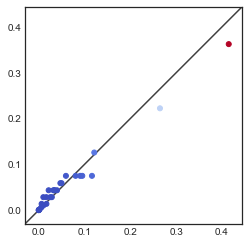

In [376]:
# plot training class frequencies versus those from leaderboard probing by iafoss
lb_prob = np.array([
0.36239782, 0.043841336, 0.075268817, 0.059322034, 0.075268817,
0.075268817, 0.043841336, 0.075268817, 0.0018, 0.0014,
0.0009, 0.043841336, 0.043841336, 0.014198783, 0.043841336,
0.0007, 0.028806584, 0.014198783, 0.028806584, 0.059322034,
0.0056, 0.126126126, 0.028806584, 0.075268817, 0.0104,
0.222493888, 0.028806584, 0.0004
])
   
# sns.regplot(ymean, lb_prob)

c = ymean**2 + lb_prob**2

fig, ax = plt.subplots()
ax.scatter(ymean, lb_prob, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [457]:
# lb probing resuluts from iafoss
# print lower and upper bound on frequencies
probe = {
0 : 0.019,
1 : 0.003,
2 : 0.005,
3 : 0.004,
4 : 0.005,
5 : 0.005,
6 : 0.003,
7 : 0.005,
8 : 0.000,
9 : 0.000,
10 : 0.000,
11 : 0.003,
12 : 0.003,
13 : 0.001,
14 : 0.003,
15 : 0.000,
16 : 0.002,
17 : 0.001,
18 : 0.002,
19 : 0.004,
20 : 0.000,
21 : 0.008,
22 : 0.002,
23 : 0.005,
24 : 0.000,
25 : 0.013,
26 : 0.002,
27 : 0.000
}

r = 0.000499
for k in range(28):

    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

0 0.3496 0.3624 0.3755 0.4147 4241 12885 Nucleoplasm
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
2 0.0673 0.0753 0.0834 0.1165 881 3621 Nucleoli
3 0.0515 0.0593 0.0672 0.0502 694 1561 Nucleoli fibrillar center
4 0.0673 0.0753 0.0834 0.0598 881 1858 Nuclear speckles
5 0.0673 0.0753 0.0834 0.0809 881 2513 Nuclear bodies
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
7 0.0673 0.0753 0.0834 0.0908 881 2822 Golgi apparatus
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
18 0.0215 0.0288 

In [459]:
order = np.argsort(ymean)
order

array([27, 15, 10,  9,  8, 20, 17, 24, 26, 16, 13, 12, 22, 18,  6, 14, 11,  1, 19,  3,  4,  5,  7, 23,  2, 21, 25,  0])

In [460]:
# sort by training frequency
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [469]:
j

0

In [473]:
# save
ka = []
fi0a = []
fia = []
fi1a = []
yma = []
ca = []
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = fi*11702.
    ka.append(k)
    fi0a.append(fi0)
    fia.append(fi)
    fi1a.append(fi1)
    yma.append(ymean[k])
    ca.append(LABEL_MAP[k])
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,
                                               ysum[k]),LABEL_MAP[k])
              
tf = pd.DataFrame({'class':ka,'name':ca,'dataset':'test',
                   'fi0':fi0a,'freq':fia,'fi1':fi1a,'ym':yma})
fname = 'test_freq.csv'
tf.to_csv(fname,index=False)
print(fname)

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [378]:
w = 1.0/np.mean(y,axis=0)
np.set_printoptions(precision=4,linewidth=80,suppress=True)
print(w)
print(w/sum(w))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1109.7142   28.4282   45.1628   57.8622
   29.1482 1479.6191   58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 2824.727 ]
[0.0003 0.0032 0.0011 0.0026 0.0022 0.0016 0.004  0.0014 0.0764 0.09   0.1446
 0.0037 0.0059 0.0075 0.0038 0.1928 0.0076 0.0193 0.0045 0.0027 0.0235 0.0011
 0.005  0.0014 0.0126 0.0005 0.0123 0.3681]


In [379]:
wc = np.clip(w,0.,1000.)
print(wc)
print(wc/sum(wc))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1000.       28.4282   45.1628   57.8622
   29.1482 1000.       58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 1000.    ]
[0.0005 0.0047 0.0016 0.0038 0.0032 0.0024 0.0059 0.0021 0.1115 0.1313 0.1901
 0.0054 0.0086 0.011  0.0055 0.1901 0.0111 0.0281 0.0066 0.004  0.0344 0.0016
 0.0074 0.002  0.0183 0.0007 0.018  0.1901]


In [380]:
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/74065 

import math

# mu in "create_class_weight" is a dampening parameter that could be tuned
def create_class_weight(labels_dict, mu=0.5):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    class_weight_log = dict()

    for key in keys:
        score = total / float(labels_dict[key])
        score_log = math.log(mu * total / float(labels_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)

    return class_weight, class_weight_log

# Class abundance for protein dataset
labels_dict = {
    0: 12885,
    1: 1254,
    2: 3621,
    3: 1561,
    4: 1858,
    5: 2513,
    6: 1008,
    7: 2822,
    8: 53,
    9: 45,
    10: 28,
    11: 1093,
    12: 688,
    13: 537,
    14: 1066,
    15: 21,
    16: 530,
    17: 210,
    18: 902,
    19: 1482,
    20: 172,
    21: 3777,
    22: 802,
    23: 2965,
    24: 322,
    25: 8228,
    26: 328,
    27: 11
}

ccw = create_class_weight(labels_dict, mu=1.0)
# print('\nTrue class weights:')
# print(create_class_weight(labels_dict)[0])
# print('\nLog-dampened class weights:')
# print(create_class_weight(labels_dict)[1])
for i in range(num_classes):
    print(i,ccw[0][i],ccw[1][i])

0 3.94 1.37
1 40.5 3.7
2 14.02 2.64
3 32.53 3.48
4 27.33 3.31
5 20.21 3.01
6 50.38 3.92
7 18.0 2.89
8 958.15 6.87
9 1128.49 7.03
10 1813.64 7.5
11 46.46 3.84
12 73.81 4.3
13 94.57 4.55
14 47.64 3.86
15 2418.19 7.79
16 95.82 4.56
17 241.82 5.49
18 56.3 4.03
19 34.27 3.53
20 295.24 5.69
21 13.45 2.6
22 63.32 4.15
23 17.13 2.84
24 157.71 5.06
25 6.17 1.82
26 154.82 5.04
27 4616.55 8.44


In [381]:
# results for single model designated as special
x = np.array([x for x in vp[special]])
x = np.clip(x,-20,20)
print(x.shape, x.min(), x.mean(), x.max())

(31072, 28) 0.12347290585211398 0.3866456491212245 0.8160920509616598


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


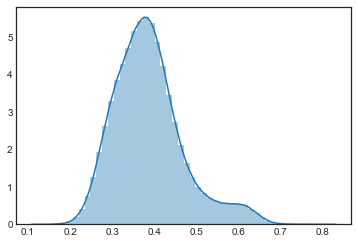

In [382]:
sns.distplot(x.flatten())

In [383]:
# t = -0.12
t = 0.5
xp = np.int32(x > t)
xps = np.sum(xp,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(31072,)
0 2.6156990216271883 8


In [384]:
print(np.mean(xp,axis=0))

[0.5886 0.0634 0.1596 0.0817 0.0842 0.1311 0.0691 0.1253 0.0016 0.0014 0.0011
 0.0556 0.045  0.0294 0.052  0.0005 0.0504 0.0156 0.0639 0.0996 0.0089 0.1884
 0.0494 0.1425 0.015  0.472  0.0199 0.0007]


In [385]:
# proportion of zero predictions
print(sum(xps==0)/x.shape[0])

0.0008689495365602471


In [386]:
f1_score(y, xp, average='macro')

0.6293527825862848

In [387]:
# make sure every image has at least one prediction
x1 = x.copy()
for i in range(x.shape[0]):
    x1[i,np.argmax(x[i])] = 30

In [388]:
t = 0.6
x1p = np.int32(x1 > t)
x1ps = np.sum(x1p,axis=1)
print(x1ps.shape)
print(x1ps.min(),x1ps.mean(),x1ps.max())

# proportion of zero predictions
print(sum(x1ps==0)/x1.shape[0])

f1_score(y, x1p, average='macro')

(31072,)
1 1.1080715756951596 3
0.0


0.6463564457144416

In [389]:
# custom thresholds to match observed proportions
thresholds = np.linspace(1.0, 0.0, 1001)
pred = x.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (x[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= ymean[j]: break
    print(j,'%6.4f' % t,'%6.4f' % ymean[j],'%6.4f' % prop, LABEL_MAP[j])
print(f1_score(y, pred, average='macro'))

0 0.5550 0.4147 0.4152 Nucleoplasm
1 0.5620 0.0404 0.0404 Nuclear membrane
2 0.5320 0.1165 0.1173 Nucleoli
3 0.5430 0.0502 0.0506 Nucleoli fibrillar center
4 0.5430 0.0598 0.0599 Nuclear speckles
5 0.5320 0.0809 0.0815 Nuclear bodies
6 0.5490 0.0324 0.0328 Endoplasmic reticulum
7 0.5310 0.0908 0.0914 Golgi apparatus
8 0.4830 0.0017 0.0017 Peroxisomes
9 0.5010 0.0014 0.0014 Endosomes
10 0.5340 0.0009 0.0009 Lysosomes
11 0.5450 0.0352 0.0353 Intermediate filaments
12 0.5580 0.0221 0.0222 Actin filaments
13 0.5400 0.0173 0.0173 Focal adhesion sites
14 0.5660 0.0343 0.0344 Microtubules
15 0.4870 0.0007 0.0007 Microtubule ends
16 0.5480 0.0171 0.0174 Cytokinetic bridge
17 0.5490 0.0068 0.0068 Mitotic spindle
18 0.5440 0.0290 0.0293 Microtubule organizing center
19 0.5410 0.0477 0.0477 Centrosome
20 0.5360 0.0055 0.0056 Lipid droplets
21 0.5280 0.1216 0.1222 Plasma membrane
22 0.5480 0.0258 0.0261 Cell junctions
23 0.5440 0.0954 0.0956 Mitochondria
24 0.5430 0.0104 0.0105 Aggresome
25 0.5430

In [390]:
# estimate thresholds by least squares, from iafoss kernel
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.95*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params, maxfev=10000)
    return p

In [391]:
# #  pred = sigmoid_np(x)
# pred = x
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# # print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [392]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.12347290585211398 0.3866456491212245 0.8160920509616598 28
Thresholds:  [0.542  0.5715 0.5458 0.5474 0.5512 0.5424 0.5551 0.5435 0.5472 0.5208 0.5367
 0.5532 0.5539 0.5494 0.5602 0.5472 0.5543 0.5375 0.5317 0.5368 0.5416 0.5292
 0.5515 0.5495 0.5668 0.5266 0.5639 0.6348]
F1 macro:  0.7039330004226357
F1 micro:  0.7418227215980026


In [393]:
# estimate thresholds by line search on observed proportions
def prop_mse(preds, targs, th=0.5):
    pm = np.mean((preds>th))
    tm = np.mean(targs)
#     print(th,pm,tm)
    return (tm - pm)**2
#     return (np.mean(targs) - np.mean((preds>th)))**2

def fit_val2(x, y, start=0.54):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.4,0.6], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [394]:
# prop_mse(pred[:,0],y[:,0], 0.618)

In [395]:
# fit_val2(pred[:,0],y[:,0])

In [396]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.12347290585211398 0.3866456491212245 0.8160920509616598 28
Thresholds:  [0.5551 0.5622 0.5325 0.5437 0.5432 0.5324 0.5497 0.5318 0.4762 0.4921 0.5408
 0.5459 0.5582 0.5406 0.5667 0.5146 0.5488 0.548  0.5447 0.5411 0.5363 0.5284
 0.5487 0.5441 0.5435 0.544  0.5501 0.5528]
F1 macro:  0.6911121359745628
F1 micro:  0.73651149968494


In [397]:
np.mean(pred[:,0] > 0.618)

0.1297953141091658

In [398]:
# model- and class-specific thresholds 
# compute best threshold to maximize f1 score by grid search

thresholds = np.linspace(0, 1.0, 101)

fm = [[f1_score(y[:,j], (x[:,j] > t).astype(int)) \
       for t in thresholds] for j in range(y.shape[1])]

besti = [np.argmax(f) for f in fm]
bestt = [thresholds[b] for b in besti]
bests = [f[b] for f,b in zip(fm,besti)]

# td = {}
# print(special)
# for j in range(y.shape[1]):
#     # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
#     plt.plot(thresholds, fm[j])
#     plt.plot(bestt[j], bests[j], "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
#     plt.title(LABEL_MAP[j] + " f1 vs threshold (%6.4f, %6.4f)" % (bestt[j], bests[j]))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()
 
print(special)
for j in range(y.shape[1]):
    print(j, "%5.3f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
print(np.mean(bests))   

preresnet_u101
0 0.540 0.8366 Nucleoplasm
1 0.570 0.8359 Nuclear membrane
2 0.540 0.7956 Nucleoli
3 0.550 0.7495 Nucleoli fibrillar center
4 0.550 0.7705 Nuclear speckles
5 0.540 0.6903 Nuclear bodies
6 0.550 0.5929 Endoplasmic reticulum
7 0.540 0.8053 Golgi apparatus
8 0.530 0.8889 Peroxisomes
9 0.520 0.9048 Endosomes
10 0.560 0.9630 Lysosomes
11 0.550 0.7572 Intermediate filaments
12 0.550 0.6862 Actin filaments
13 0.560 0.6845 Focal adhesion sites
14 0.570 0.8620 Microtubules
15 0.560 0.6667 Microtubule ends
16 0.550 0.4267 Cytokinetic bridge
17 0.550 0.3614 Mitotic spindle
18 0.530 0.5283 Microtubule organizing center
19 0.540 0.5993 Centrosome
20 0.540 0.6071 Lipid droplets
21 0.530 0.6539 Plasma membrane
22 0.550 0.6188 Cell junctions
23 0.550 0.7853 Mitochondria
24 0.550 0.6986 Aggresome
25 0.530 0.6775 Cytosol
26 0.570 0.5421 Cytoplasmic bodies
27 0.640 0.7368 Rods & rings
0.7044800198339988


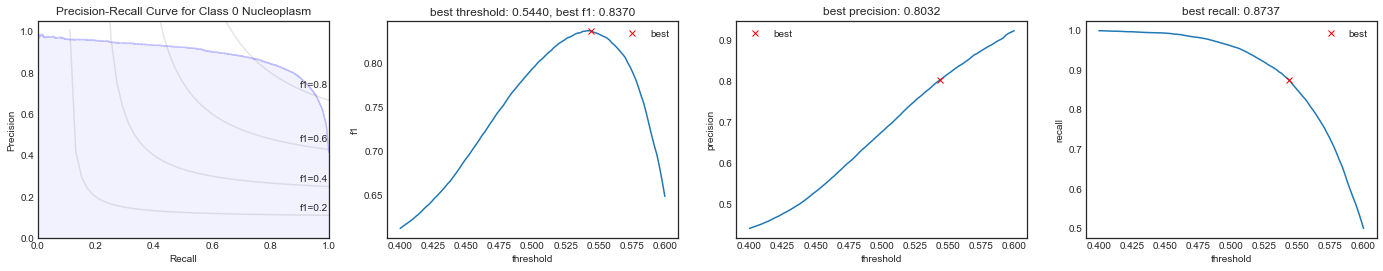

<Figure size 432x288 with 0 Axes>

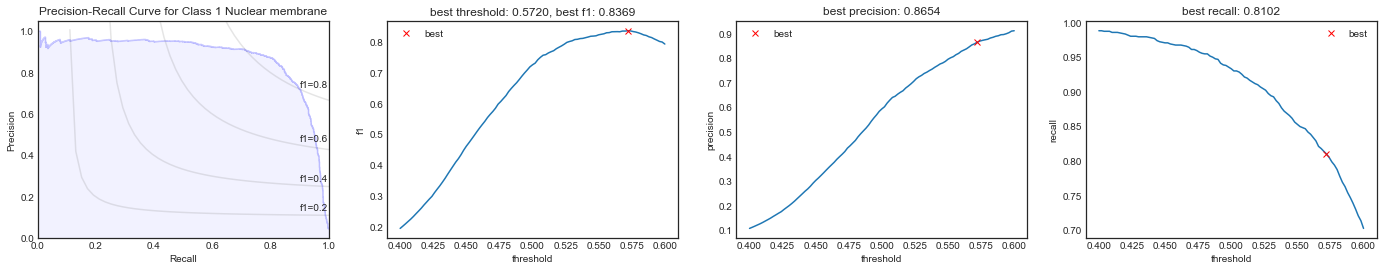

<Figure size 432x288 with 0 Axes>

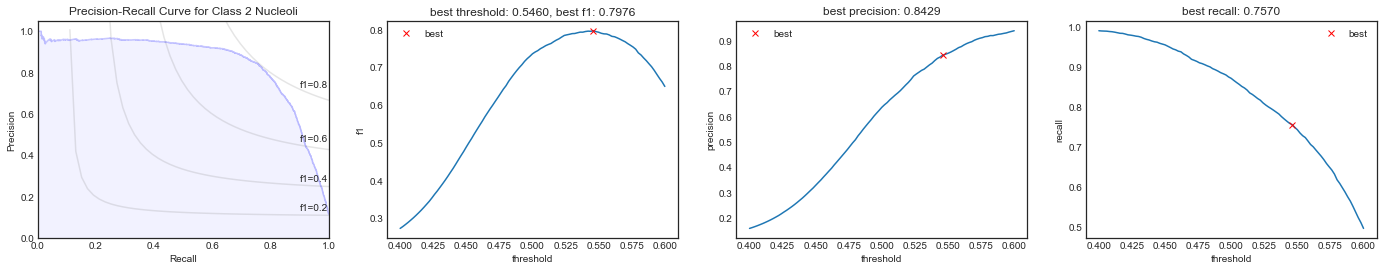

<Figure size 432x288 with 0 Axes>

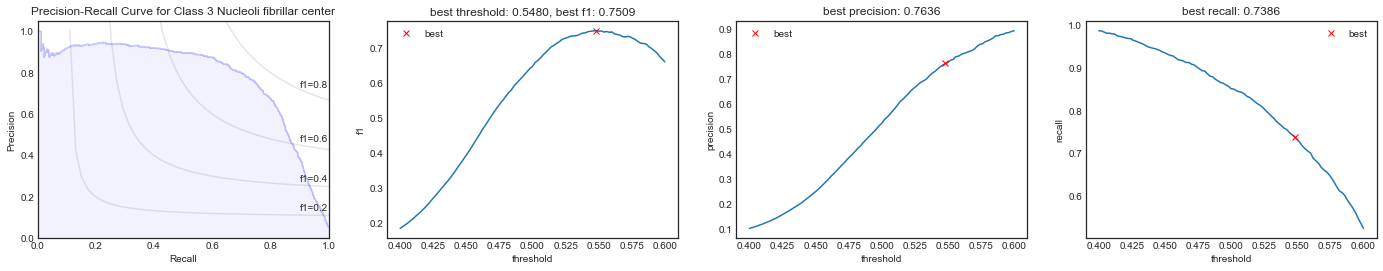

<Figure size 432x288 with 0 Axes>

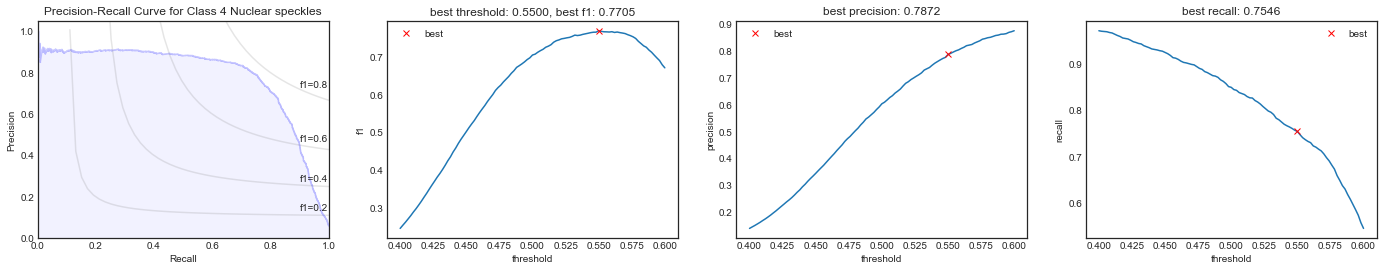

<Figure size 432x288 with 0 Axes>

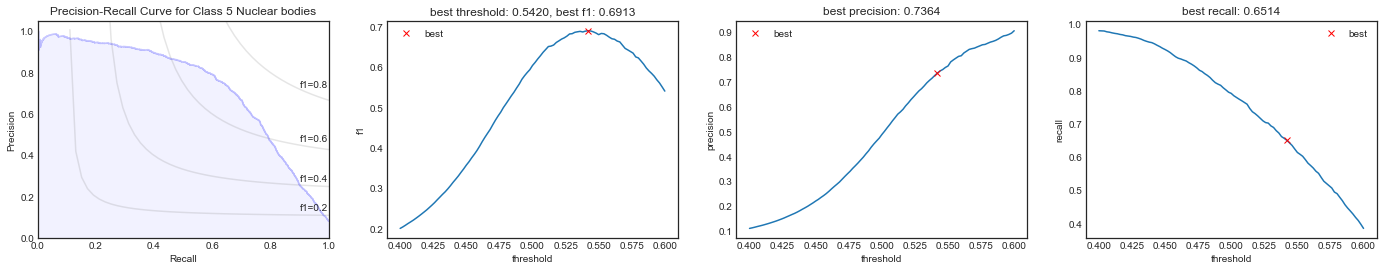

<Figure size 432x288 with 0 Axes>

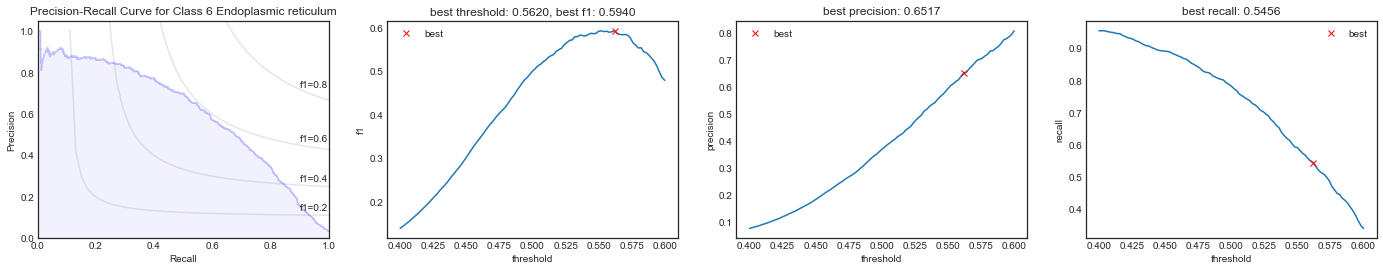

<Figure size 432x288 with 0 Axes>

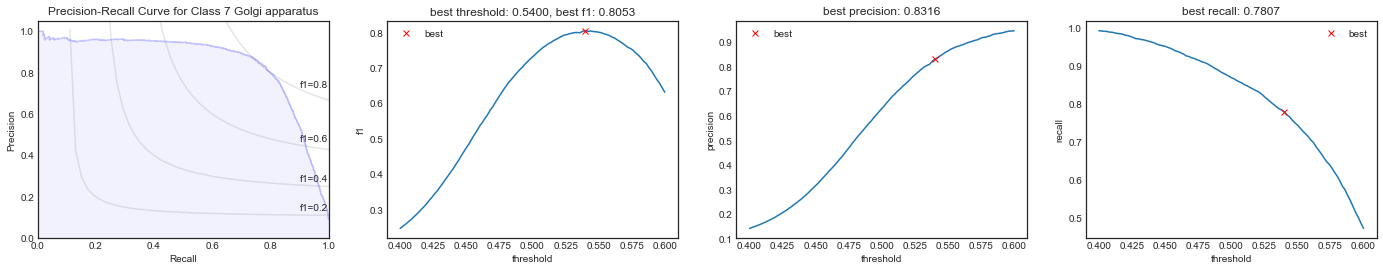

<Figure size 432x288 with 0 Axes>

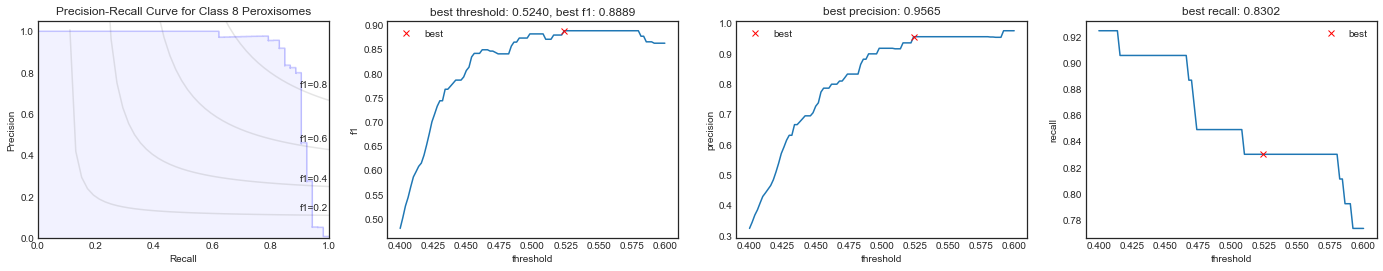

<Figure size 432x288 with 0 Axes>

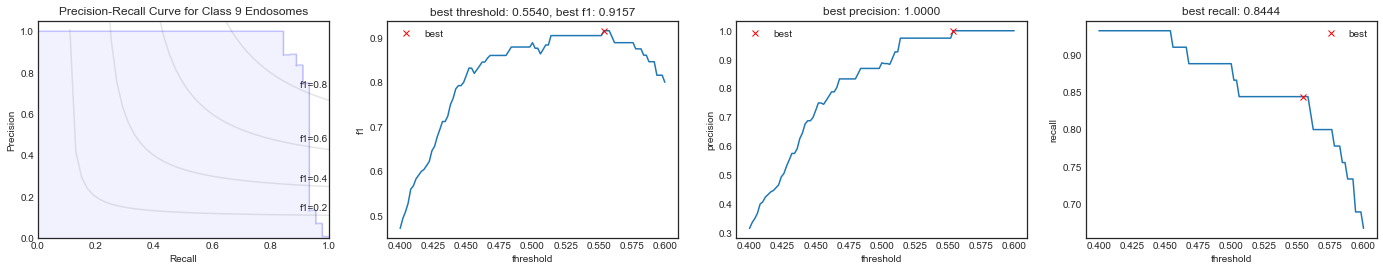

<Figure size 432x288 with 0 Axes>

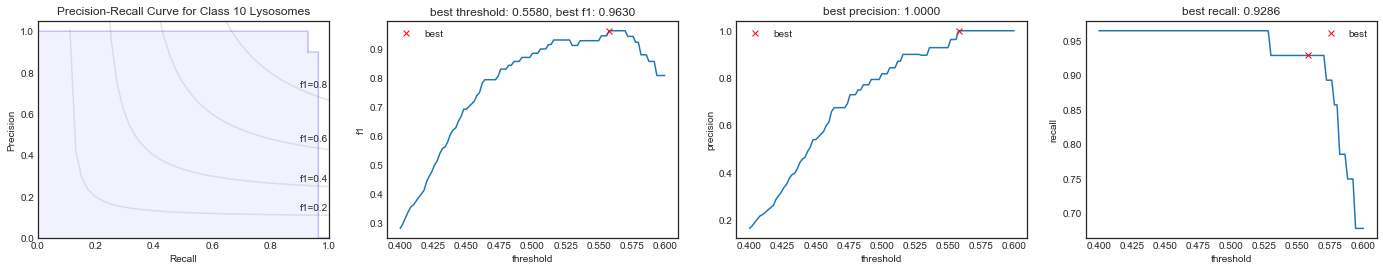

<Figure size 432x288 with 0 Axes>

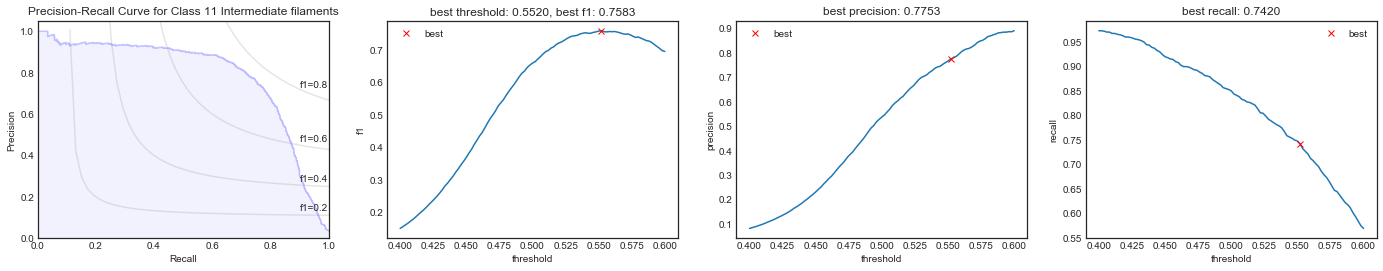

<Figure size 432x288 with 0 Axes>

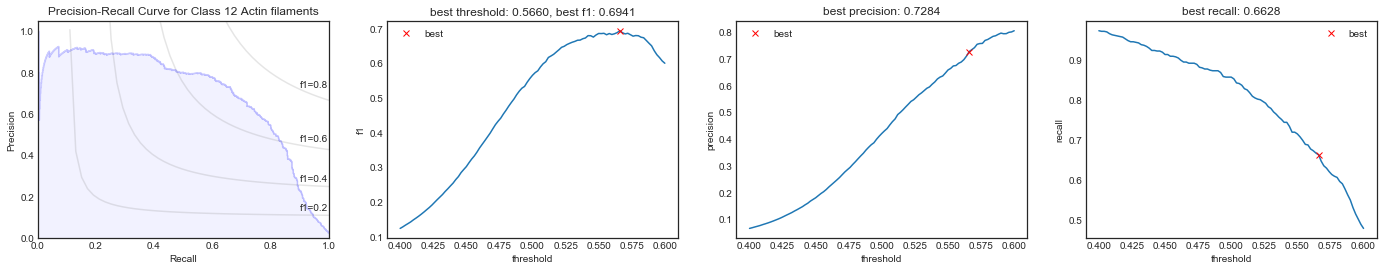

<Figure size 432x288 with 0 Axes>

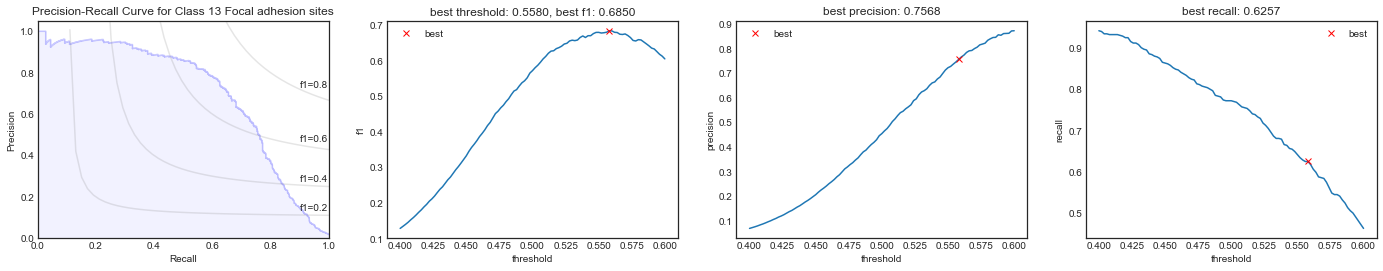

<Figure size 432x288 with 0 Axes>

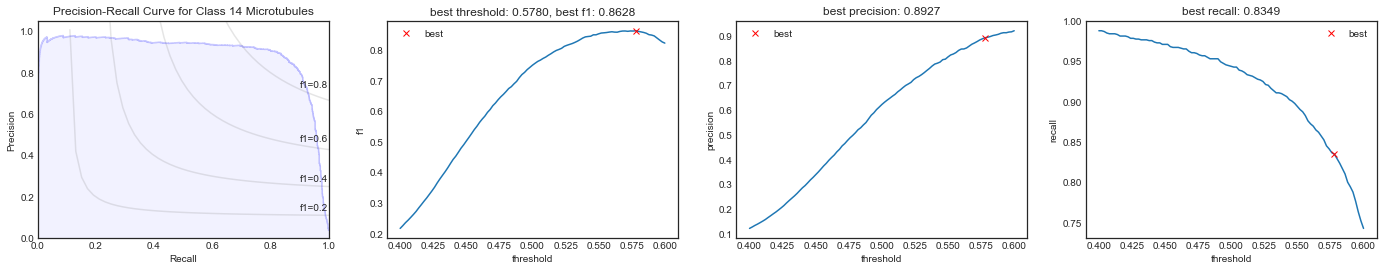

<Figure size 432x288 with 0 Axes>

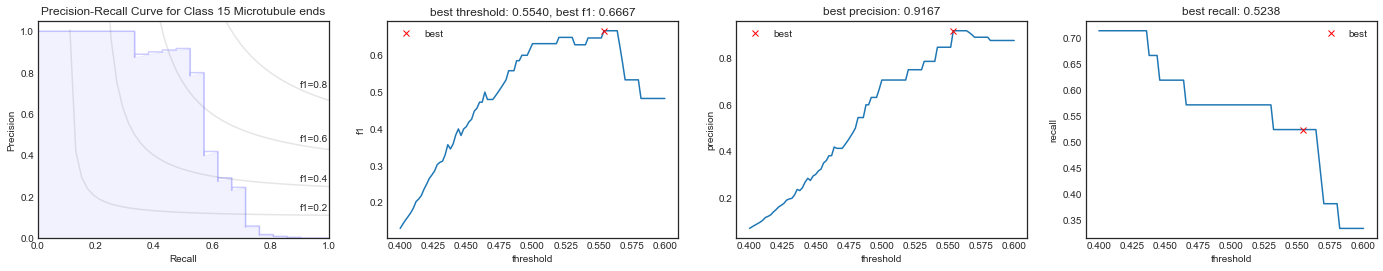

<Figure size 432x288 with 0 Axes>

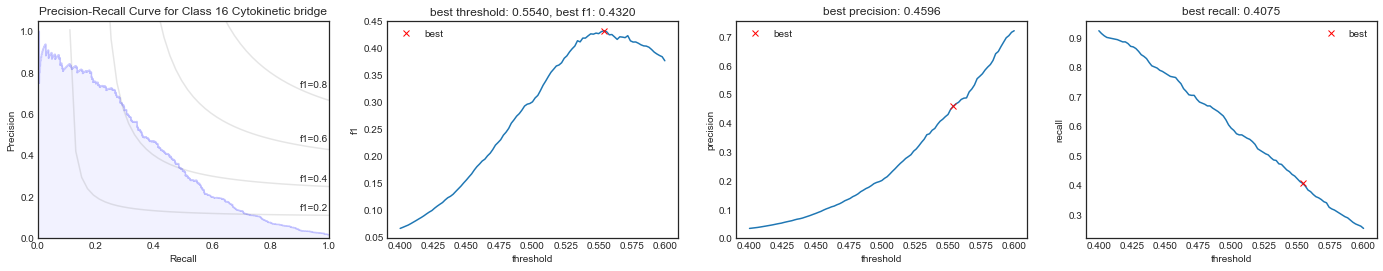

<Figure size 432x288 with 0 Axes>

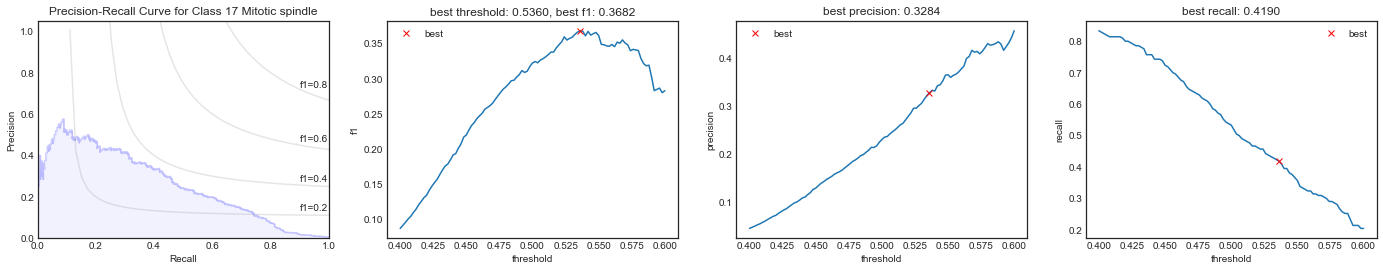

<Figure size 432x288 with 0 Axes>

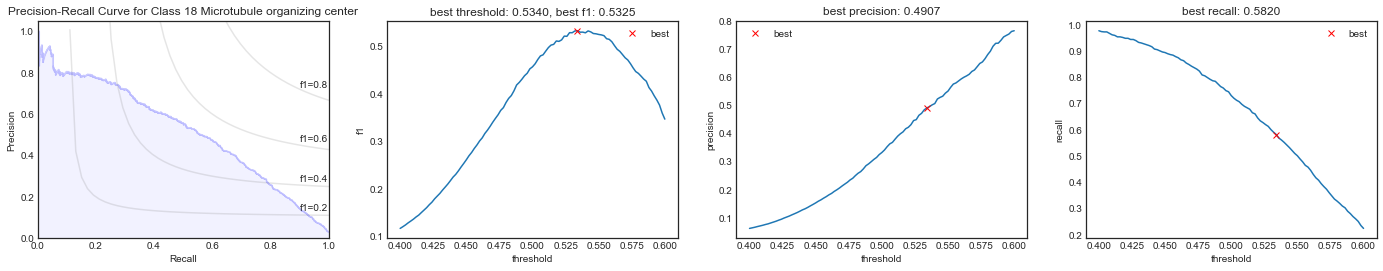

<Figure size 432x288 with 0 Axes>

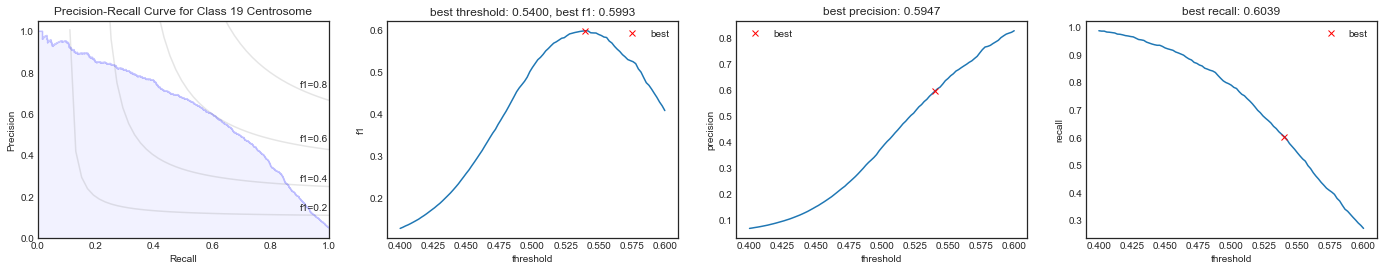

<Figure size 432x288 with 0 Axes>

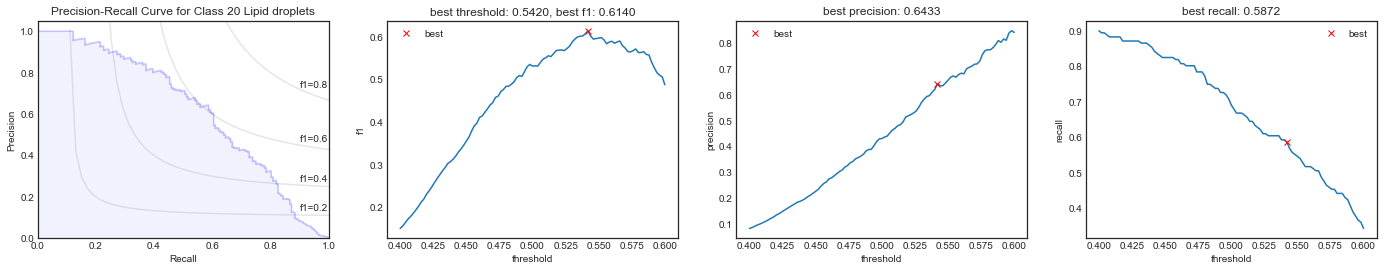

<Figure size 432x288 with 0 Axes>

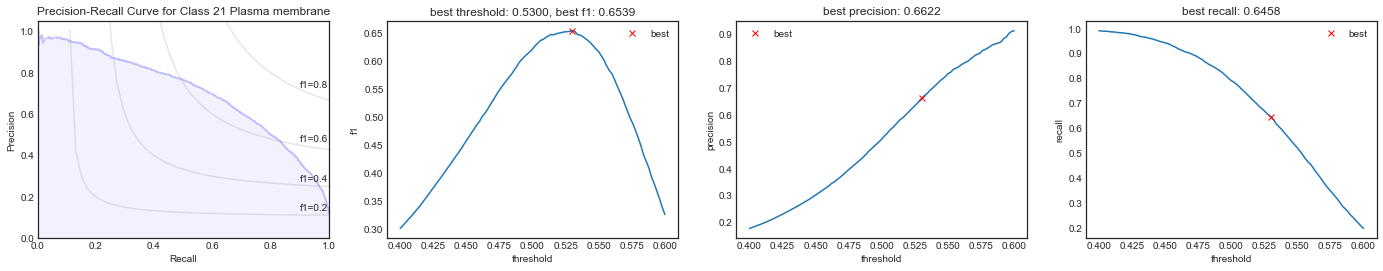

<Figure size 432x288 with 0 Axes>

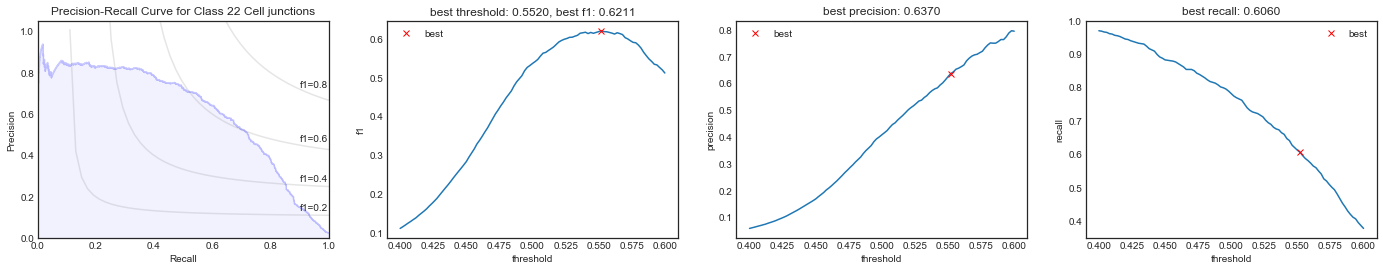

<Figure size 432x288 with 0 Axes>

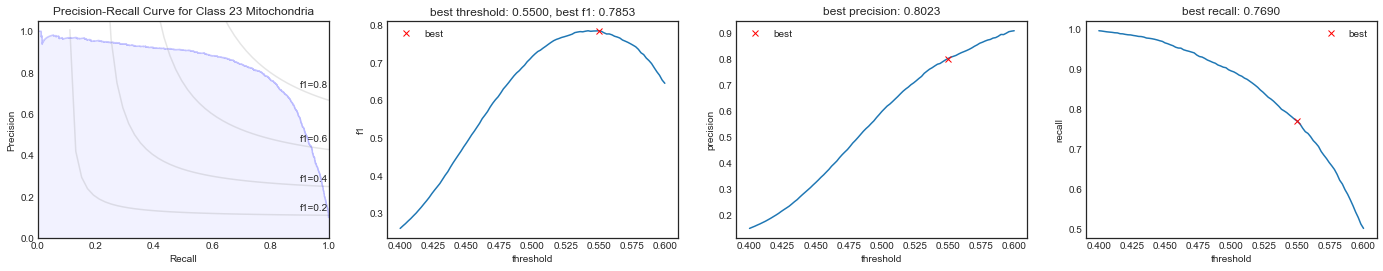

<Figure size 432x288 with 0 Axes>

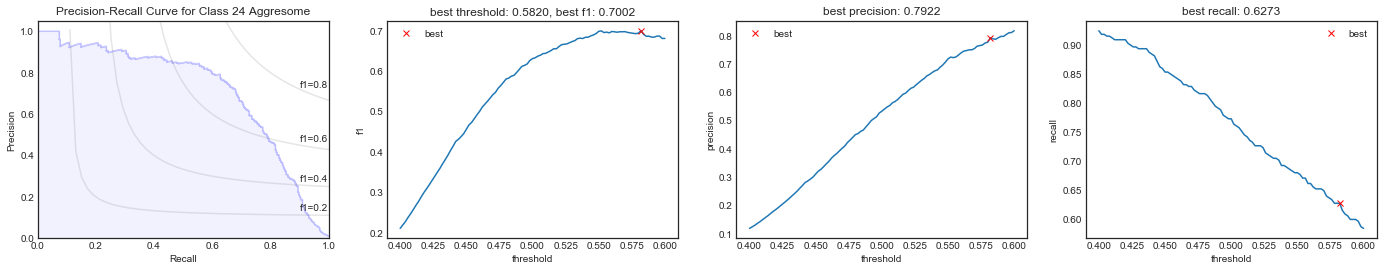

<Figure size 432x288 with 0 Axes>

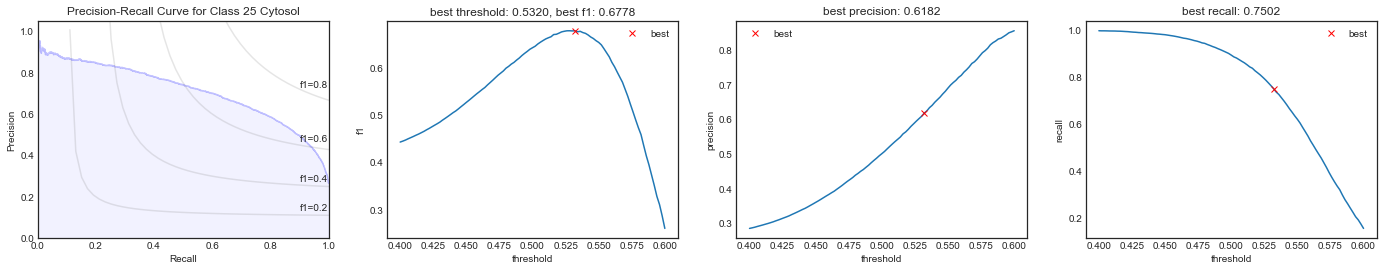

<Figure size 432x288 with 0 Axes>

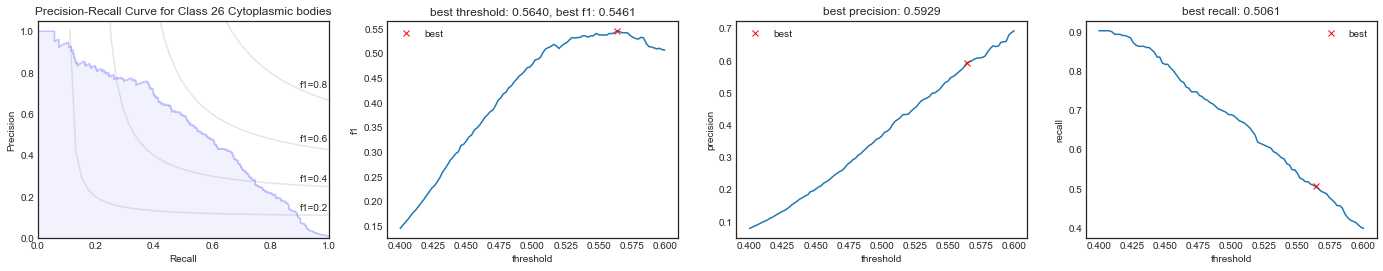

<Figure size 432x288 with 0 Axes>

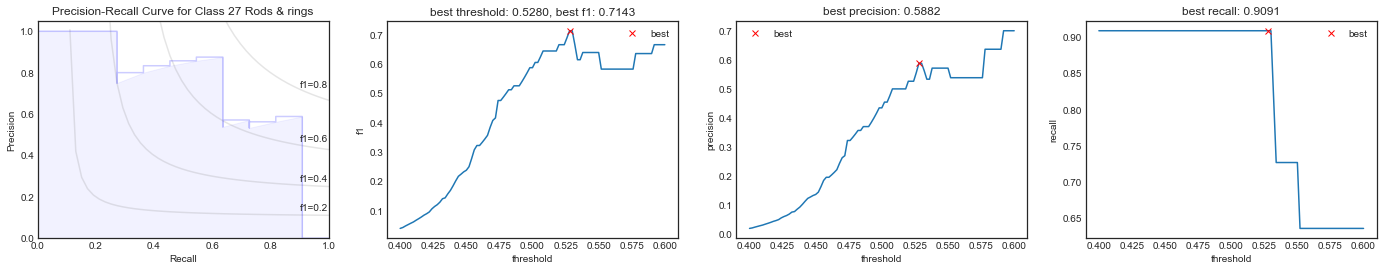

<Figure size 432x288 with 0 Axes>

In [399]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], x[:, i])
    average_precision[i] = average_precision_score(y[:, i], x[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    thresholds = np.linspace(0.4, 0.6, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    bests = fm[besti] 
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [400]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), x.ravel())

average_precision["macro"] = average_precision_score(y, x, average="macro")
print('Average precision score, macro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

average_precision["micro"] = average_precision_score(y, x, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))


Average precision score, macro-averaged over all classes: 0.719
Average precision score, micro-averaged over all classes: 0.787


In [401]:
# for i in range(len(th)):
#     print(i,np.round(th[i],decimals=2))

In [402]:
# print(np.mean(x > th,axis=0))

In [403]:
# f1_score(y, xp, average='samples')

In [404]:
f1_score(y, xp, average='micro')

0.6723763223456538

In [405]:
z = [(y,x) for y,x in zip(y,xp) if np.sum(x) == 0]
print(len(z))

27


In [406]:
# z[:5]

In [407]:
yz = np.array([t[0] for t in z])
xz = np.array([t[1] for t in z])
f1_score(yz,xz,average='macro')

0.0

0.0 0.6902169452729442 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


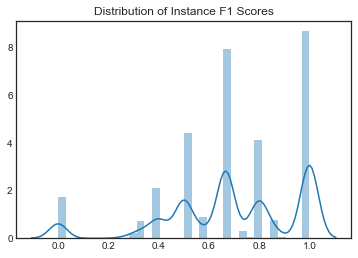

<Figure size 432x288 with 0 Axes>

In [408]:
f1b = np.array([f1_score(yi, xpi, average='binary') \
                 for yi,xpi in zip(y,xp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Instance F1 Scores")
plt.show()
plt.gcf().clear()

In [409]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)
f = []
for m in mnames:
    ff = np.array(list(vp[m])).flatten()
    print(m, ff.shape)
    f.append(ff)
# print(mnames)
r = np.corrcoef(f)
print(r)   

air_u67 (870016,)
preresnet_u67 (870016,)
preresnet_u101 (870016,)
resnet_w65 (870016,)
se_resnext_u29 (870016,)
iv3_q11 (870016,)
irv2_q10 (870016,)
resnet_q24 (870016,)
resnet_q25 (870016,)
resnet_q40 (870016,)
gap_q12 (870016,)
nas_q11 (870016,)
se_resnext_q26 (870016,)
se_resnext_q28 (870016,)
bni_q0 (870016,)
bni_q1 (870016,)
iv3_q12 (870016,)
iv3_u11 (870016,)
iv3_u12 (870016,)
irv2_u12 (870016,)
resnet_q26 (870016,)
resnet_q27 (870016,)
resnet_u25 (870016,)
resnet_u31 (870016,)
resnet_u56 (870016,)
resnet_u60 (870016,)
resnet_u61 (870016,)
resnet_u63 (870016,)
resnet_u65 (870016,)
resnet_u101 (870016,)
se_resnet_u50 (870016,)
gap_u14 (870016,)
bni_u1 (870016,)
bni_u2 (870016,)
[[1.    0.9   0.899 ... 0.84  0.842 0.87 ]
 [0.9   1.    0.908 ... 0.824 0.828 0.865]
 [0.899 0.908 1.    ... 0.826 0.828 0.863]
 ...
 [0.84  0.824 0.826 ... 1.    0.9   0.855]
 [0.842 0.828 0.828 ... 0.9   1.    0.851]
 [0.87  0.865 0.863 ... 0.855 0.851 1.   ]]


In [410]:
loc = [i for i,m in enumerate(mnames) if m == special][0]
rloc = r[:,loc]
print(rloc)
order = np.argsort(rloc)
for i in range(1,min(len(rloc)+1,7)):
    print('%5.3f' % rloc[order[-i]],mnames[order[-i]])

[0.899 0.908 1.    0.88  0.866 0.815 0.802 0.812 0.819 0.801 0.786 0.754 0.795 0.794 0.828 0.829 0.816 0.806 0.867 0.88  0.808 0.814 0.82  0.802 0.889 0.847 0.842 0.873 0.902 0.886 0.87  0.826 0.828
 0.863]
1.000 preresnet_u101
0.908 preresnet_u67
0.902 resnet_u65
0.899 air_u67
0.889 resnet_u56
0.886 resnet_u101


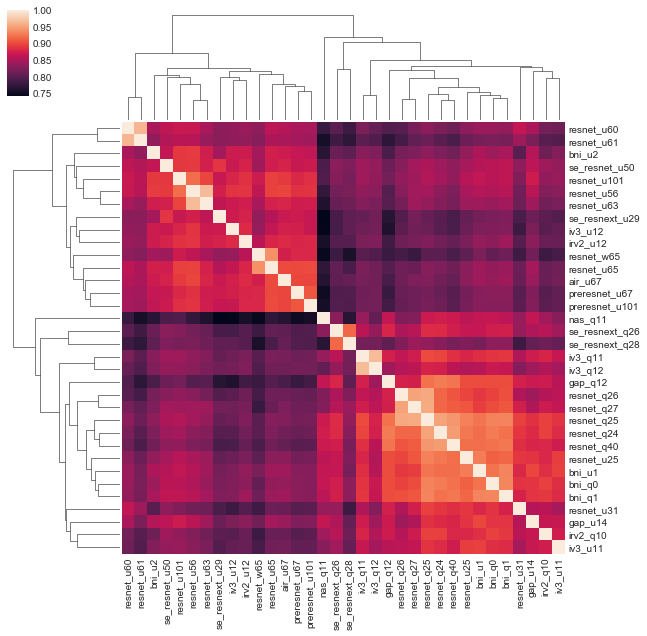

In [411]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [412]:
# f = []
# for m in mnames:
#     f.append(np.array(list(vp[m])).flatten())
# print(mnames)
# print(np.corrcoef(f))   

In [413]:
print(f[0].min(),f[0].max())

0.07309180687967914 0.8267237209178944


In [414]:
# # model-specific global thresholds
# # compute best single logit threshold for computed ensemble

# # for probabilities
# thresholds = np.linspace(0.1, 0.9, 1001)

# # for logits
# # thresholds = np.linspace(-1, 1, 101)

# # for ranks
# # thresholds = np.linspace(0.9, 1, 101)

# # thresholds = [-0.4]

# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# else: mthresh = {}
# # mthresh = {}

# for i in range(nm):
# # for i in [3]:

#     mname = vp.columns[i+offset]

#     tv = np.array(list(vp.iloc[:,offset+i].values))
    
#     if mname in mthresh or np.sum(np.isnan(tv)) > 0: continue

#     scores = np.array([f1_score(y, np.int32(tv > threshold),
#                                  average='macro') for threshold in thresholds])

#     besta = np.argmax(scores)
#     threshold_best = thresholds[besta]
#     score_best = scores[besta]
#     print(i, mname, "%4.2f" % threshold_best, "%6.4f" % score_best)
#     mthresh[mname] = threshold_best
    
#     plt.plot(thresholds, scores)
#     plt.plot(threshold_best, score_best, "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
# #     plt.title(mname + " f1 vs threshold (%6.4f, %6.4f)" % (threshold_best, score_best))
#     plt.title(mname + " threshold: %6.4f  f1: %6.4f" % (threshold_best, score_best))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()

# pickle.dump(mthresh,open(fname,'wb'))
# print(mthresh)

In [415]:
vp.columns

Index(['Target', 'y', 'air_u67', 'preresnet_u67', 'preresnet_u101',
       'resnet_w65', 'se_resnext_u29', 'iv3_q11', 'irv2_q10', 'resnet_q24',
       'resnet_q25', 'resnet_q40', 'gap_q12', 'nas_q11', 'se_resnext_q26',
       'se_resnext_q28', 'bni_q0', 'bni_q1', 'iv3_q12', 'iv3_u11', 'iv3_u12',
       'irv2_u12', 'resnet_q26', 'resnet_q27', 'resnet_u25', 'resnet_u31',
       'resnet_u56', 'resnet_u60', 'resnet_u61', 'resnet_u63', 'resnet_u65',
       'resnet_u101', 'se_resnet_u50', 'gap_u14', 'bni_u1', 'bni_u2'],
      dtype='object')

In [416]:
# # model- and class-specific thresholds
# # compute best logit threshold for computed ensemble

# # thresholds = np.linspace(-2, 2, 101)

# # thresholds = [-0.4]

# fname = 'cthresh.pkl'
# # if os.path.isfile(fname): cthresh = pickle.load(open(fname,'rb'))
# cthresh = {}

# for i in range(nm):
# # for i in [2]:

#     mname = vp.columns[i+offset]
#     tv = np.array(list(vp.iloc[:,offset+i].values))

#     fm = [[f1_score(y[:,j], (tv[:,j] > t).astype(int)) \
#            for t in thresholds] for j in range(y.shape[1])]
    
#     besti = [np.argmax(f) for f in fm]
#     bestt = [thresholds[b] for b in besti]
#     bests = [f[b] for f,b in zip(fm,besti)]
#     print(mname, np.mean(bests))
    
#     td = {}
#     for j in range(y.shape[1]):
#         # print()
#         # print(j, LABEL_MAP[j], "%4.2f" % bestt[j], "%6.4f" % bests[j])
        
#         # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
        
#         # print(cm[j], '%4.2f' % fm[j])
#         # print('')
#         td[j] = np.round(bestt[j],decimals=2)
    
#     cthresh[mname] = td
#     print()
    
# pickle.dump(cthresh,open(fname,'wb'))
# # print(cthresh)
# print(fname)

optimizing f1 by hillcliming
model 0 f1 for air_u67 = 0.7085
model 1 f1 for preresnet_u67 = 0.7087
model 2 f1 for preresnet_u101 = 0.7039
model 3 f1 for resnet_w65 = 0.7074
model 4 f1 for se_resnext_u29 = 0.6978
model 5 f1 for iv3_q11 = 0.6371
model 6 f1 for irv2_q10 = 0.6203
model 7 f1 for resnet_q24 = 0.6337
model 8 f1 for resnet_q25 = 0.6278
model 9 f1 for resnet_q40 = 0.6229
model 10 f1 for gap_q12 = 0.6127
model 11 f1 for nas_q11 = 0.5267
model 12 f1 for se_resnext_q26 = 0.5831
model 13 f1 for se_resnext_q28 = 0.6187
model 14 f1 for bni_q0 = 0.6300
model 15 f1 for bni_q1 = 0.6180
model 16 f1 for iv3_q12 = 0.6473
model 17 f1 for iv3_u11 = 0.6555
model 18 f1 for iv3_u12 = 0.6840
model 19 f1 for irv2_u12 = 0.6697
model 20 f1 for resnet_q26 = 0.6268
model 21 f1 for resnet_q27 = 0.6554
model 22 f1 for resnet_u25 = 0.6527
model 23 f1 for resnet_u31 = 0.6539
model 24 f1 for resnet_u56 = 0.6895
model 25 f1 for resnet_u60 = 0.6731
model 26 f1 for resnet_u61 = 0.6656
model 27 f1 for resnet_

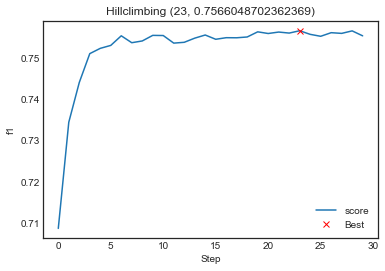

    step  midx     score             mod      f1_0
0      0     1  0.708709   preresnet_u67  0.708709
1      1     4  0.734439  se_resnext_u29  0.697768
2      2     3  0.744071      resnet_w65  0.707361
3      3     9  0.751059      resnet_q40  0.622935
4      4    23  0.752338      resnet_u31  0.653915
5      5     2  0.753053  preresnet_u101  0.703933
6      6    21  0.755378      resnet_q27  0.655447
7      7     4  0.753706  se_resnext_u29  0.697768
8      8     0  0.754129         air_u67  0.708500
9      9    15  0.755484          bni_q1  0.618014
10    10     1  0.755443   preresnet_u67  0.708709
11    11    22  0.753606      resnet_u25  0.652725
12    12     3  0.753804      resnet_w65  0.707361
13    13     2  0.754809  preresnet_u101  0.703933
14    14    18  0.755572         iv3_u12  0.684011
15    15    21  0.754536      resnet_q27  0.655447
16    16    30  0.754921   se_resnet_u50  0.668430
17    17    16  0.754900         iv3_q12  0.647281
18    18     0  0.755093       

<Figure size 432x288 with 0 Axes>

In [417]:
# oof = small

# hillclimbing
# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))
nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0
rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                    'score':np.zeros(nstep)})
currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
threshold = 0.49
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)
print('optimizing ' + metric + ' by hillcliming')


# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc']

num_classes = 28
th = np.zeros(num_classes)
threshold_best = threshold

# maximizing
bestScore = -9999999
single = pd.DataFrame({'mod':np.repeat("",nm)})
start = 0
for step in range(start,nstep):
    single[metric+'_'+str(step)] = np.nan

for step in range(start,nstep):
    currIndex = 0
    currScore = -9999999

    for i in range(nm):

        mname = vp.columns[i+offset]
        
        tv = np.array(list(vp.iloc[:,offset+i].values))

        # mean-center
#         tv = tv - np.mean(tv)

        # adjust by model-specific threshold
#         tv = tv - mthresh[mname]
        
        # adjust by model-class-specific thresholds
#         for j in range(tv.shape[1]):
#             tv[:,j] = tv[:,j] - cthresh[mname][j]

        if np.sum(np.isnan(tv)) > 0: continue
            
        if step==0:
            tryEnsemble = tv
        else:
            # running mean
            tryEnsemble = (step * currEnsemble + tv)/(step+1)
            # full matrix
            # choose median or mean here
            # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
            # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
            # quantiles are a lot slower
            # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

        if metric=="f1":
#             # estimate new class-specific thresholds by least squares, very slow
#             th = fit_val(tryEnsemble,y)
#             th[th<0.1] = 0.1
#             tryScore = f1_score(y, np.int32(tryEnsemble > th),
#                                 average='macro')

            # estimate new class-specific thresholds by line search, slow
            for j in range(num_classes):
                th[j] = fit_val1(tryEnsemble[:,j],y[:,j])
            tryScore = f1_score(y, np.int32(tryEnsemble > th),
                                average='macro')
            
#             # estimate new class-specific thresholds to match proportions, medium
#             for j in range(num_classes):
#                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
#             tryScore = f1_score(y, np.int32(tryEnsemble > th),
#                                 average='macro')

#             # fixed threshold, fast
#             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
#                                 average='macro')

            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="iou":
            tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                        pred_eps=pred_eps)
            if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
        elif metric=="mse":
            tryScore = -mse(y,tryEnsemble)
        elif metric=="mae": 
            tryScore = -mae(y,tryEnsemble)
        elif metric=="winsorized_mae": 
            tryScore = -winsorized_mae(y,tryEnsemble+intercept)
        elif metric=="rmse":
            tryScore = -rmse(y,tryEnsemble)
        elif metric=="corr":
            tryScore = cor(y,tryEnsemble)
        elif metric=="mcc":
            opt = eval_mcc3(y,tryEnsemble,cut=T)
            tryScore = opt[1]
            cut = opt[2]
            # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
            # tryScore = opt$objective
        elif metric=="logloss":
            # tryScore = -logLoss(vp$y,tryEnsemble,)
            tryScore = -eval_logloss2(tryEnsemble,y)
        elif metric=="auc":
            tryScore = auc2(y,tryEnsemble)
        elif metric=="auprc":
            tryScore = auprc(tryEnsemble, y)
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
        elif metric=="aurocpr":
            auroc = auc(y,tryEnsemble)
            # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
            tryScore = (auroc + auprc)/2
        elif metric=="sqwk":
            tryScore = sqwk(y,tryEnsemble,1,8)
        
        ok = 1
        if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
        if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

        if (tryScore > currScore) and (ok==1):
            currIndex = i
            currScore = tryScore
            if (step==0):
                saveEnsemble = tv.copy()
            else:
                # running mean
                saveEnsemble = tryEnsemble.copy()
                # save whole matrix
                # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
            if metric in cut_mets: currCut = cut

        # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
        if (step==0):
            if (metric=="mcc"):
                print("model",i,metric,"for",vp.columns[i+offset],"=",tryScore,"  cut =",cut,"\n")
            else:
                print("model",i,metric,"for",vp.columns[i+offset],"= %6.4f" % tryScore)

        if step==0:
            single.loc[i,'mod'] = vp.columns[i+offset]  
        single.iloc[i,step+1] = tryScore

    if metric=="mcc":
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore,"  cut =",currCut)
    else:
        print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
            metric,"= %6.4f" % currScore)

    currEnsemble = saveEnsemble.copy()
    if currScore > bestScore:
        bestScore = currScore
        bestStep = step
        bestEnsemble = currEnsemble.copy()
        if metric in cut_mets: bestCut = currCut

    rez.iloc[step,0] = step
    rez.iloc[step,1] = currIndex
    rez.iloc[step,2] = currScore

if (metric=="mcc"):
    print("best step =",bestStep,"  best",metric,"=",bestScore,"  best cut =",bestCut)
else:
    print("best step =",bestStep,"  best",metric,"=",bestScore)

rez0 = rez.copy()

# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# plot hillclimbing
print('')
plt.plot(rez0.step, rez0.score)
plt.plot(bestStep, bestScore, "xr", label="Best")
plt.xlabel("Step")
plt.ylabel(metric)
plt.title("Hillclimbing ({}, {})".format(bestStep, bestScore))
plt.legend()
plt.show()
plt.gcf().clear()

# display the weights
rez = rez.iloc[:(bestStep+1)]
# print(rez)

single0 = single.iloc[:,:2]

rez['midx'] = rez['midx'].astype(int)
rez = rez.join(single0,how='left',on='midx')
print(rez)
print('')

rez['weight'] = 1
tb = rez.loc[:,['midx','weight']].groupby('midx').count()
# print(tb)
# print(single)

tb = tb.join(single0,how='left')
print(tb)

bestEnsemble0 = bestEnsemble.copy()

In [418]:
pred = bestEnsemble0
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

0.17173054813379662 0.3917909886549306 0.6930933087180039 28
Thresholds:  [0.537 0.547 0.53  0.523 0.531 0.521 0.538 0.526 0.478 0.493 0.5   0.523 0.535 0.535 0.557 0.476 0.531 0.499 0.525 0.521 0.516 0.525 0.536 0.53  0.514 0.526 0.526 0.506]
F1 macro:  0.7566048702362369
F1 micro:  0.7757663668890823


In [419]:
pred = bestEnsemble0
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th1 = np.zeros(num_classes)
for i in range(num_classes):
    th1[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th1)
print('F1 macro: ',f1_score(y, pred>th1, average='macro'))
print('F1 micro: ',f1_score(y, pred>th1, average='micro'))

0.17173054813379662 0.3917909886549306 0.6930933087180039 28
Thresholds:  [0.549 0.539 0.522 0.523 0.525 0.515 0.536 0.515 0.455 0.464 0.476 0.513 0.534 0.512 0.549 0.453 0.517 0.502 0.526 0.524 0.501 0.525 0.535 0.523 0.511 0.536 0.514 0.476]
F1 macro:  0.7382059047396512
F1 micro:  0.7697276433171194


(0.43574095722047806, 0.5697414394735913)

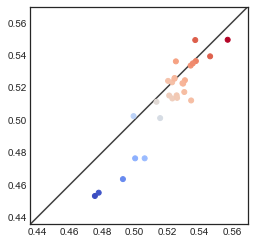

In [420]:
c = th**2 + th1**2

fig, ax = plt.subplots()
ax.scatter(th, th1, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [463]:
# pick = [8, 9, 10, 15, 20, 24, 27]
pick = [8, 9, 10, 15, 20, 27]
thp = th[pick]
th1p = th1[pick]
np = len(pick)
for j in range(np):
    print(pick[j], thp[j], th1p[j], thp[j] - th1p[j])

8 0.47795440704961906 0.4552207856315601 0.022733621418058958
9 0.49288118654080765 0.4635921578063257 0.02928902873448197
10 0.5004033441354361 0.47639851535854305 0.024004828776893028
15 0.47561215859269346 0.45320149119254116 0.022410667400152295
20 0.5158252945027393 0.5011896836522559 0.014635610850483372
27 0.5062781404272265 0.4763998118304242 0.02987832859680234


In [464]:
pick = [16,17,18]
thp = th[pick]
th1p = th1[pick]
np = len(pick)
for j in range(np):
    print(pick[j], thp[j], th1p[j], thp[j] - th1p[j])

16 0.5307015989415651 0.517270830622363 0.013430768319202091
17 0.4994384186931402 0.5024225698547897 -0.0029841511616495175
18 0.5247278745468229 0.5259142321995319 -0.0011863576527090247


(0.43574095722047806, 0.5697414394735913)

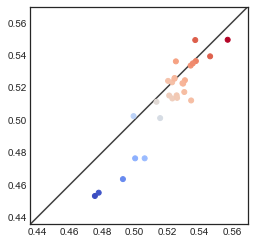

In [420]:
fig, ax = plt.subplots()
ax.scatter(th, th1, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [421]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

best = np.array(th)
approx = np.array(th1).reshape(-1, 1)
model = lm.fit(approx,best)

th1p = lm.predict(approx)
print(th1p)

print(lm.intercept_)
print(lm.coef_)
print(lm.score(approx,best))
print('F1 macro: ',f1_score(y, pred>th1p, average='macro'))

[0.546 0.539 0.528 0.528 0.529 0.523 0.537 0.523 0.483 0.488 0.497 0.522 0.535 0.521 0.546 0.482 0.524 0.514 0.53  0.529 0.513 0.53  0.536 0.528 0.52  0.537 0.522 0.497]
0.17958645333545176
[0.666]
0.8657253156093134
F1 macro:  0.7491179814892751


(0.463307089007593, 0.5697414394735913)

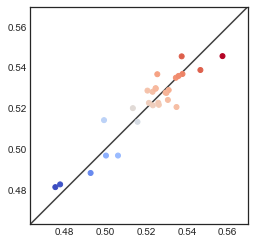

In [422]:
c = th**2 + th1**2

fig, ax = plt.subplots()
ax.scatter(th, th1p, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [423]:
pred = bestEnsemble0
print('F1 macro: ',f1_score(y, pred > th1, average='macro'))

F1 macro:  0.7382059047396512


In [424]:
pred = bestEnsemble0
print('F1 macro: ',f1_score(y, pred > (0.094 + 0.827*th1), average='macro'))

F1 macro:  0.7437392746547358


In [425]:
# # estimate thresholds by line search on observed proportions
# def prop_mse(preds, targs, th=0.5):
#     return (np.mean(targs) - np.mean((preds>th)))**2

# def fit_val2(x, y, start=0.5):
#     params = np.array([start])
#     wd = 1e-5
# #     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
#     error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
#     return p

In [426]:
# # estimate thresholds by line search
# def F1_hard(preds, targs, th=0.5):
#     return -f1_score(targs,  (preds>th).astype(int))

# def fit_val1(x, y, start=0.5):
#     params = np.array([start])
#     wd = 1e-5
# #     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
#     error = lambda p: np.array(F1_hard(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
# #     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
#     return p

In [427]:
# pred = x
# num_classes = x.shape[1]
# print(pred.min(),pred.mean(),pred.max(),num_classes)
# name_label_dict = LABEL_MAP
# th = np.zeros(num_classes)
# for i in range(num_classes):
#     th[i] = fit_val2(pred[:,i],y[:,i])
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

f1_score(y, pred>1.001*th1, average='macro')

0.7386754757126347

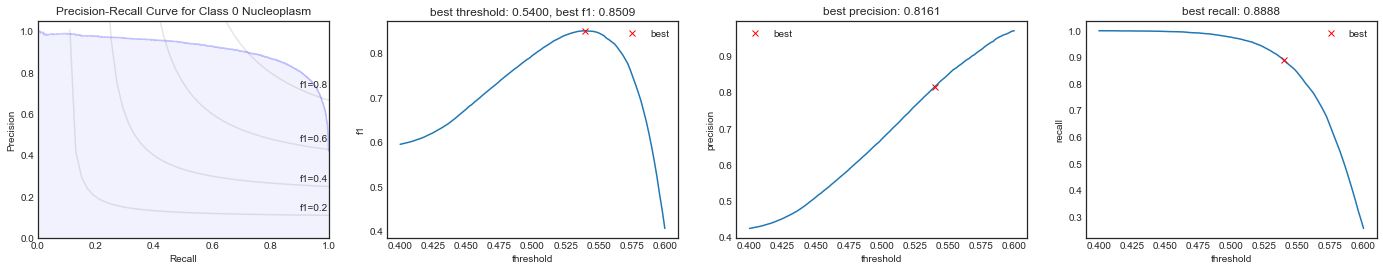

<Figure size 432x288 with 0 Axes>

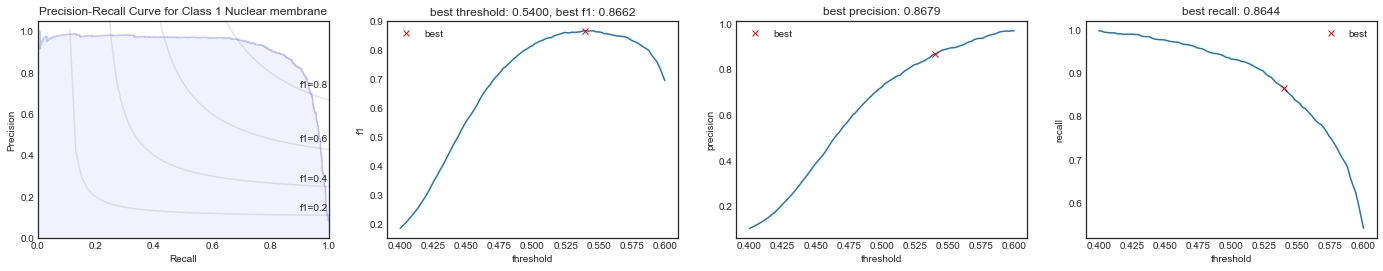

<Figure size 432x288 with 0 Axes>

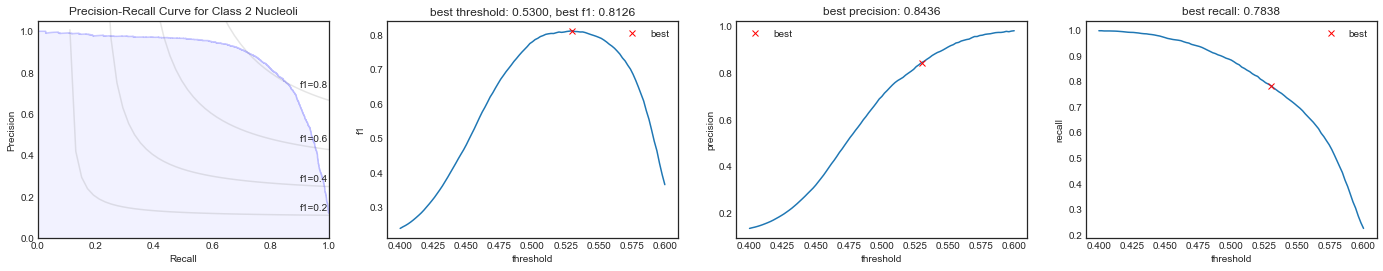

<Figure size 432x288 with 0 Axes>

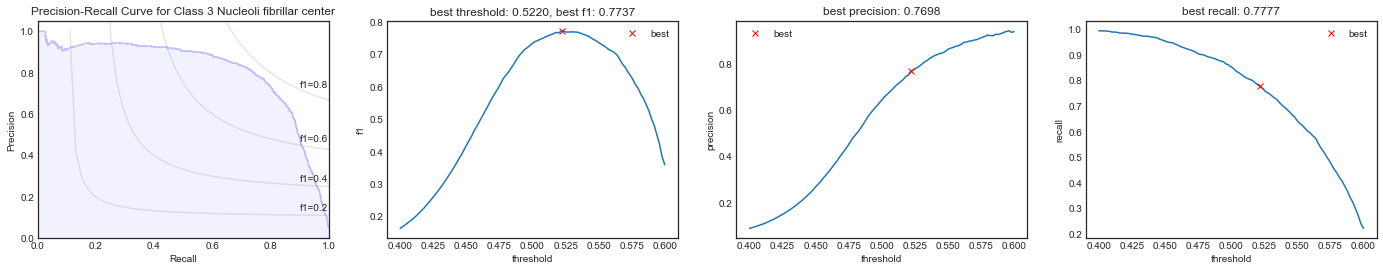

<Figure size 432x288 with 0 Axes>

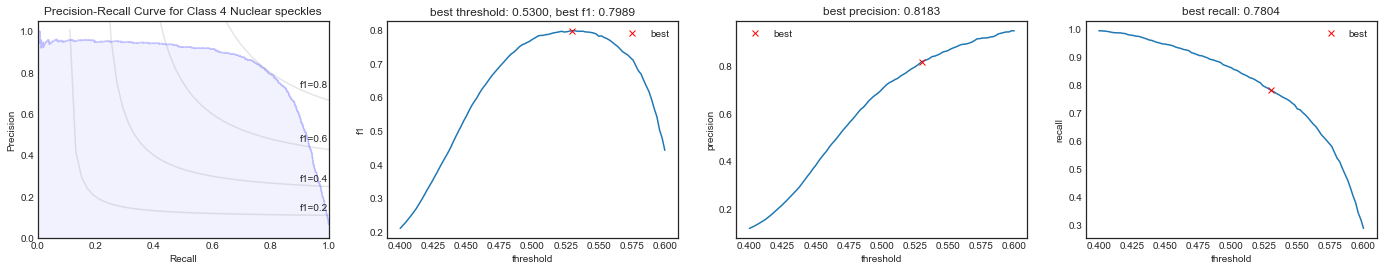

<Figure size 432x288 with 0 Axes>

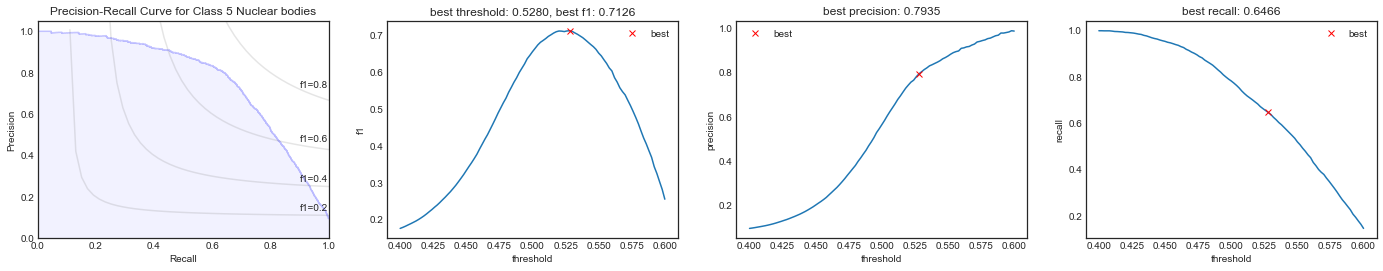

<Figure size 432x288 with 0 Axes>

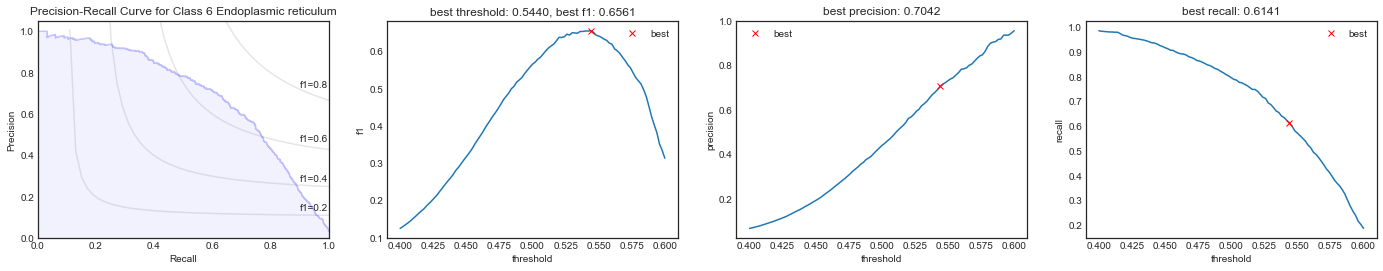

<Figure size 432x288 with 0 Axes>

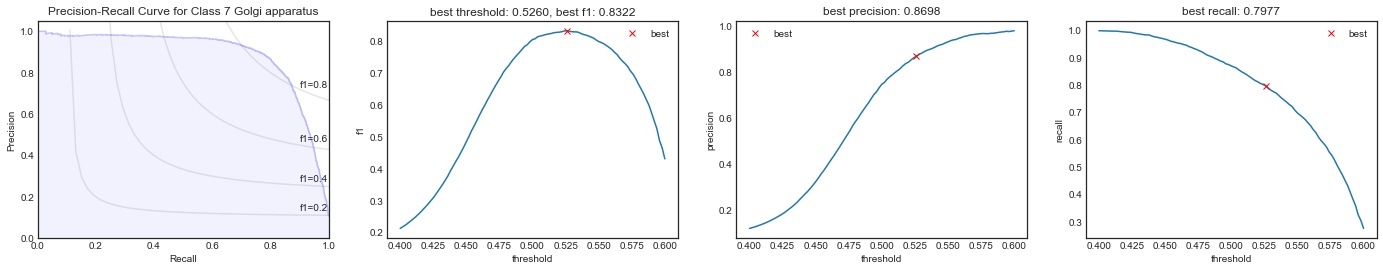

<Figure size 432x288 with 0 Axes>

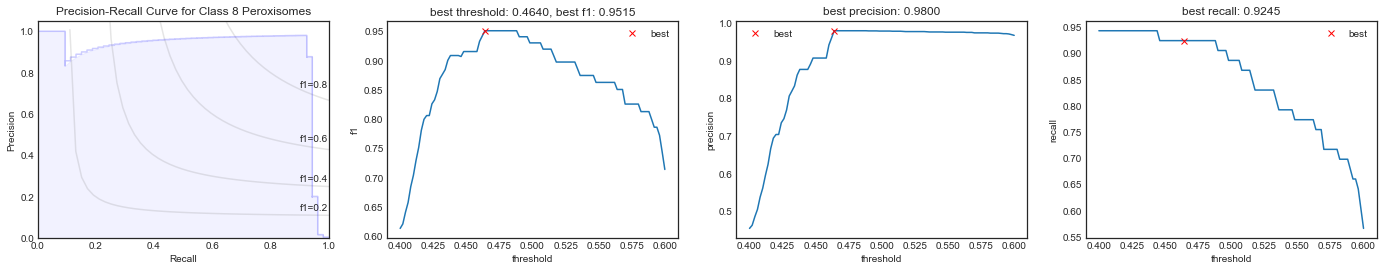

<Figure size 432x288 with 0 Axes>

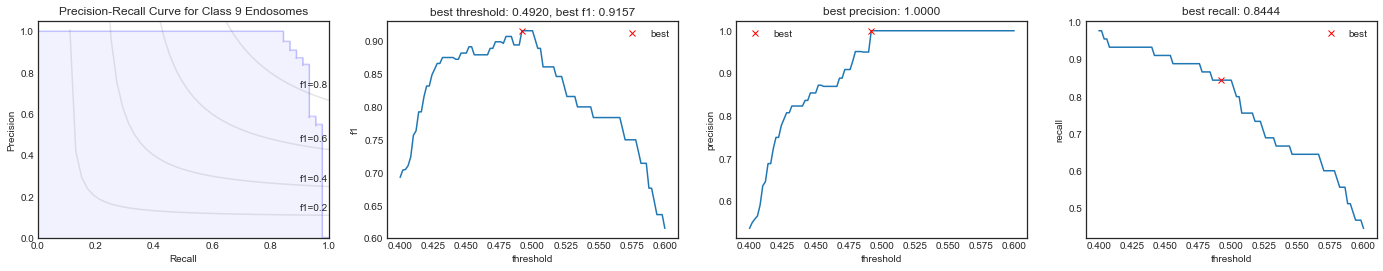

<Figure size 432x288 with 0 Axes>

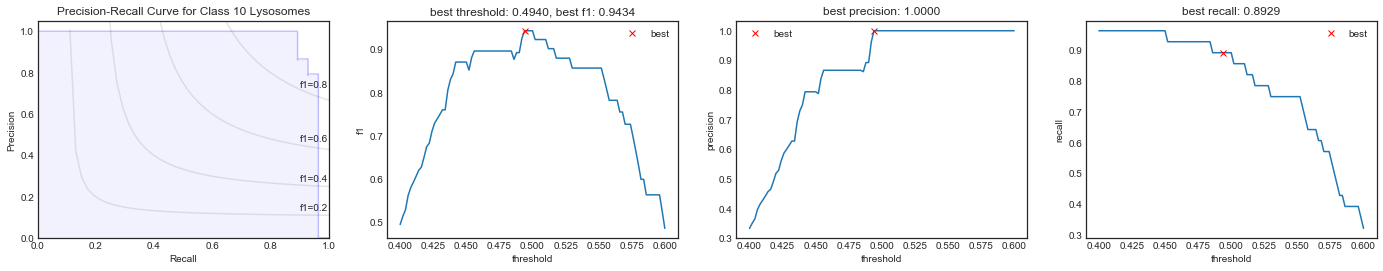

<Figure size 432x288 with 0 Axes>

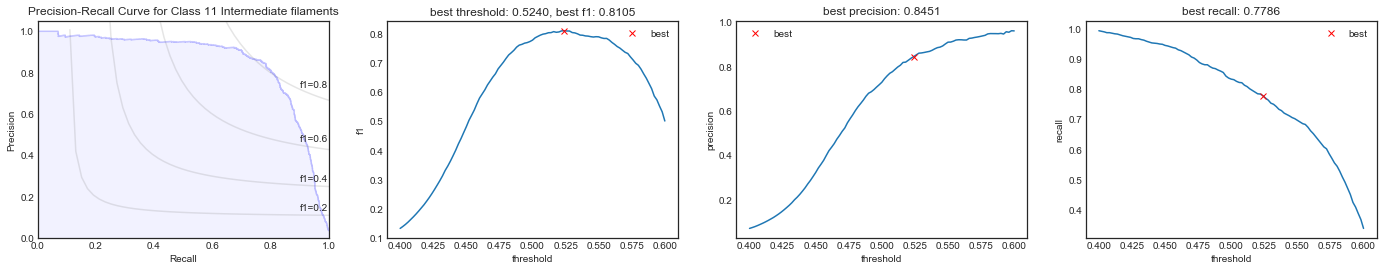

<Figure size 432x288 with 0 Axes>

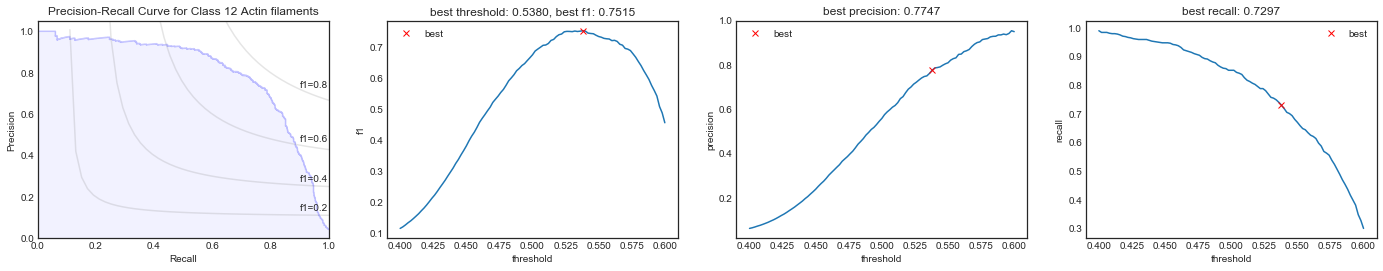

<Figure size 432x288 with 0 Axes>

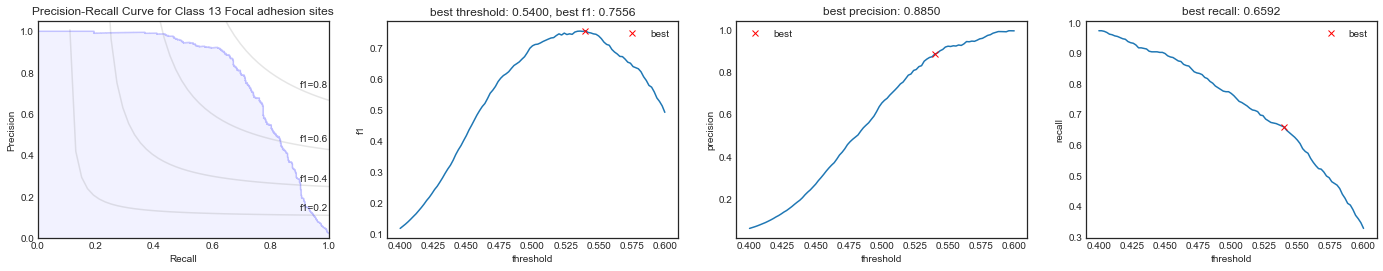

<Figure size 432x288 with 0 Axes>

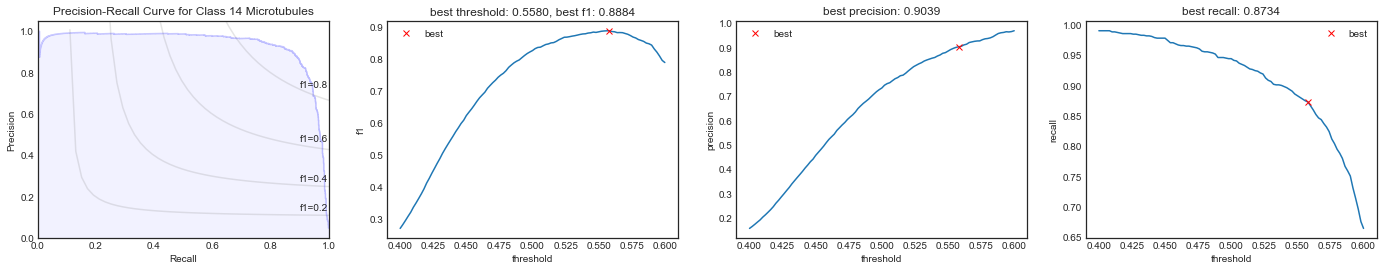

<Figure size 432x288 with 0 Axes>

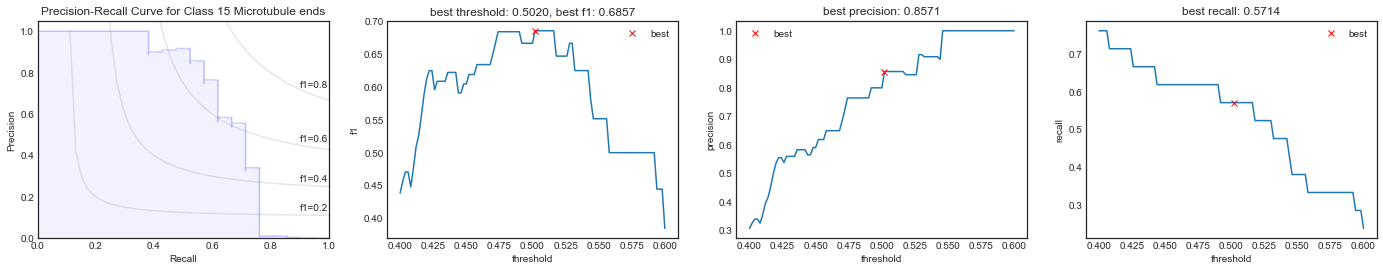

<Figure size 432x288 with 0 Axes>

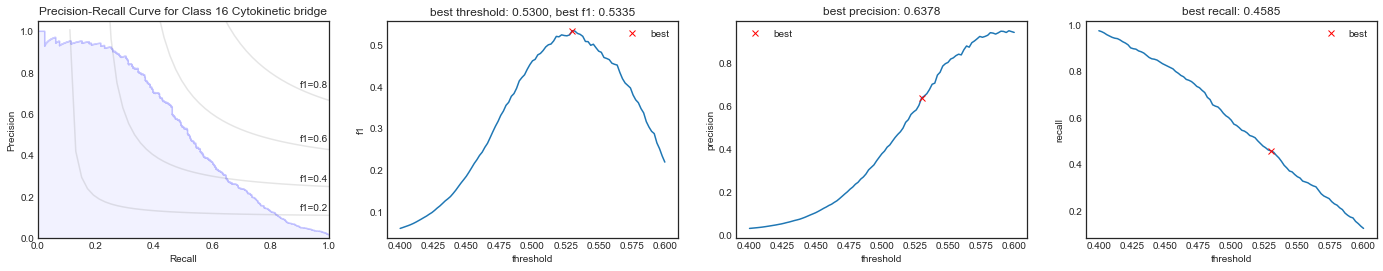

<Figure size 432x288 with 0 Axes>

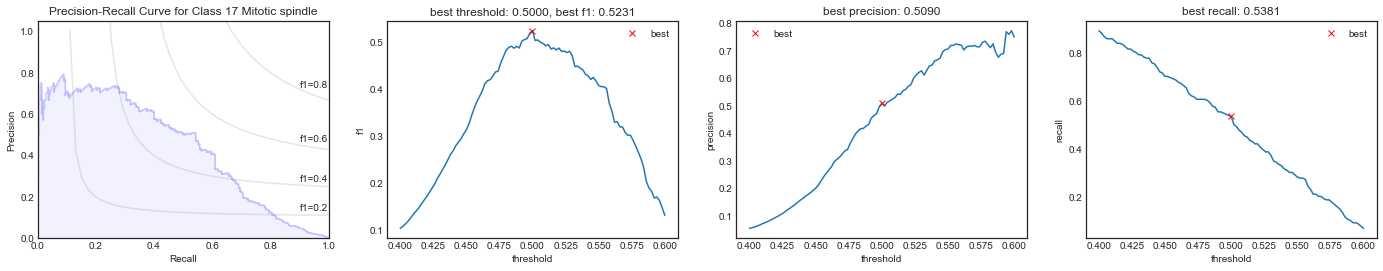

<Figure size 432x288 with 0 Axes>

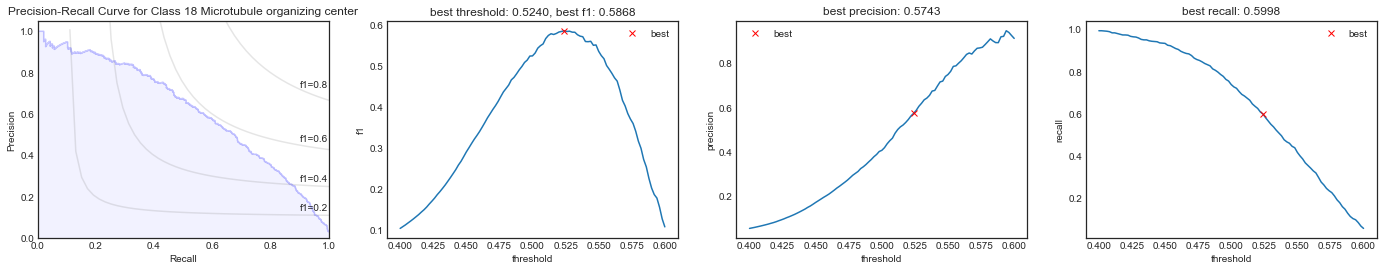

<Figure size 432x288 with 0 Axes>

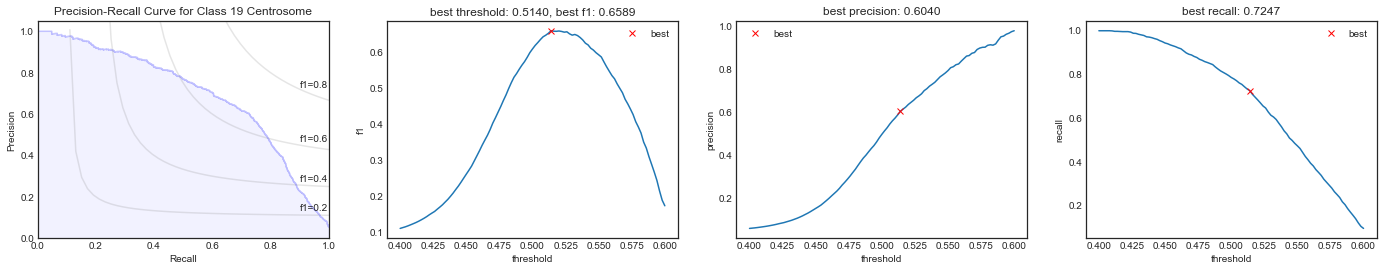

<Figure size 432x288 with 0 Axes>

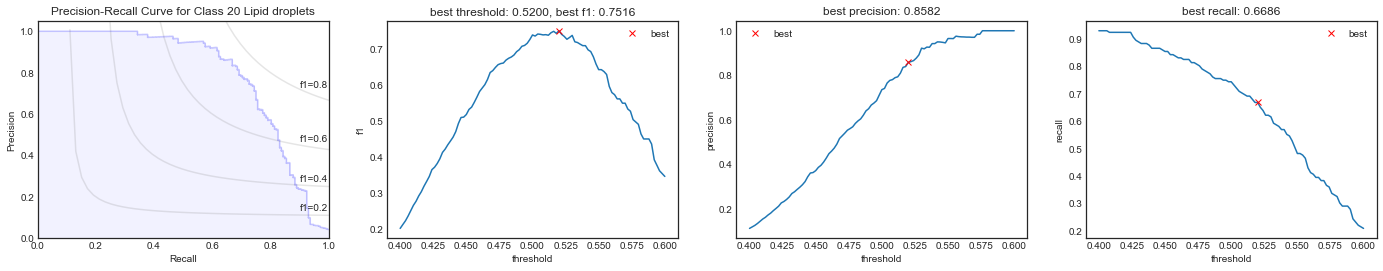

<Figure size 432x288 with 0 Axes>

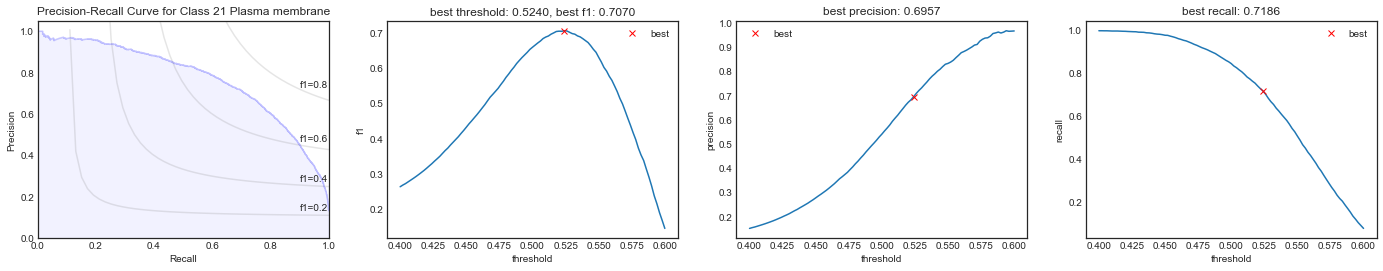

<Figure size 432x288 with 0 Axes>

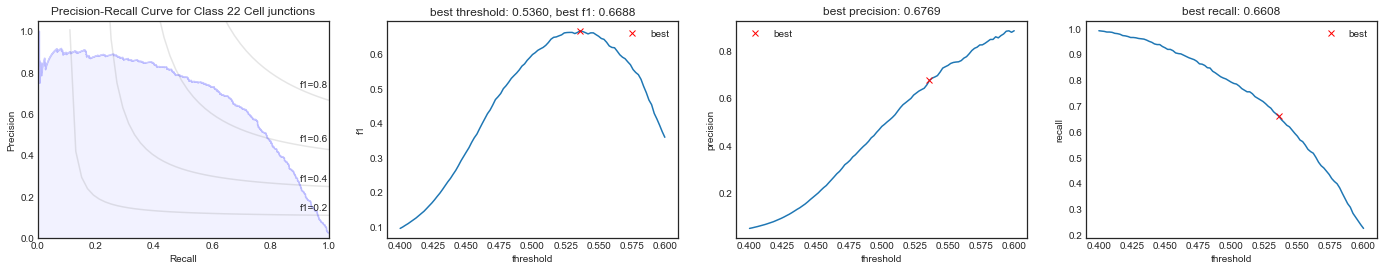

<Figure size 432x288 with 0 Axes>

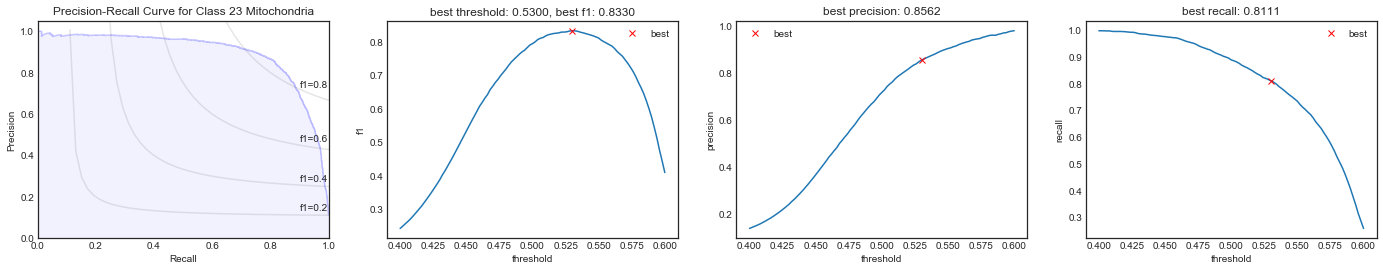

<Figure size 432x288 with 0 Axes>

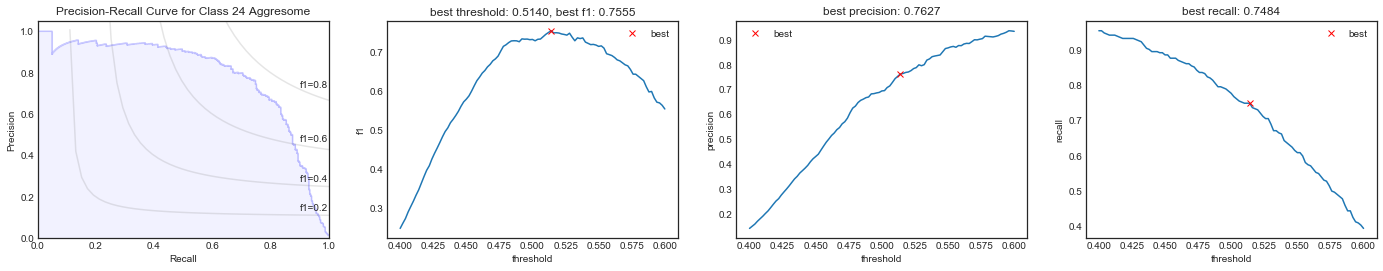

<Figure size 432x288 with 0 Axes>

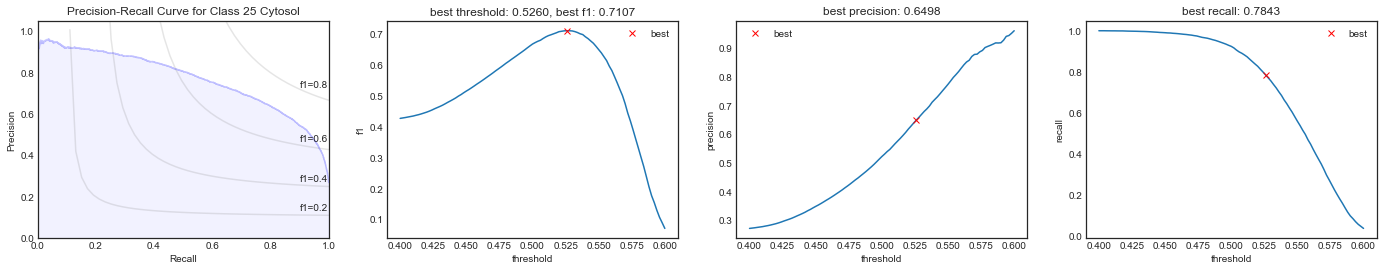

<Figure size 432x288 with 0 Axes>

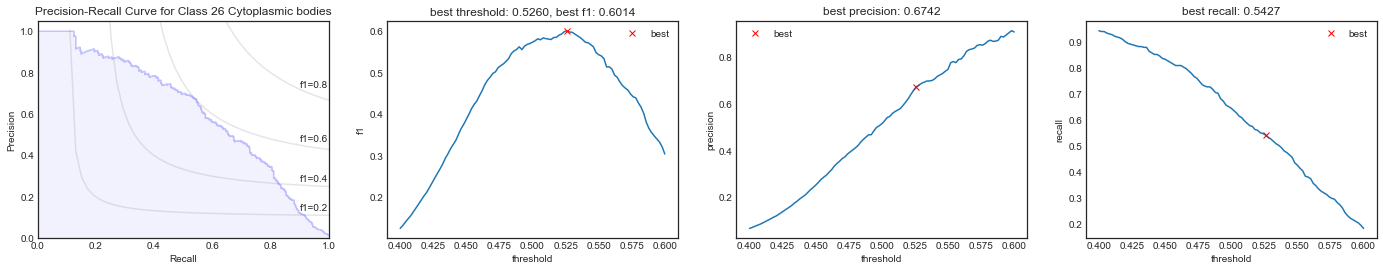

<Figure size 432x288 with 0 Axes>

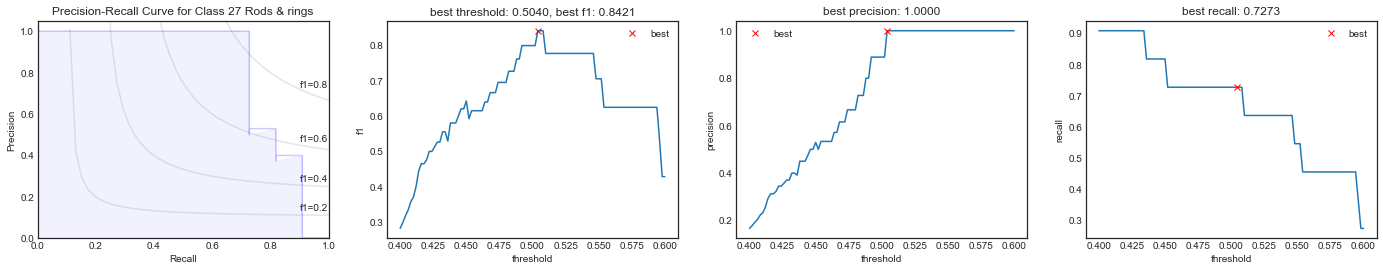

<Figure size 432x288 with 0 Axes>

In [428]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)
ta = []
fma = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], bestEnsemble0[:, i])
    average_precision[i] = average_precision_score(y[:, i], bestEnsemble0[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    thresholds = np.linspace(0.4, 0.6, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    ta.append(bestt)
    bests = fm[besti] 
    fma.append(bests)
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (bestEnsemble0[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [429]:
np.mean(fma)

0.7563427137923814

In [430]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]
pma = [precision_score(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]
rma = [recall_score(y[:,i], (bestEnsemble0[:,i]  > th[i]).astype(int)) \
       for i in range(y.shape[1])]

print('macro f1','%6.4f' % np.mean(fma))
print()

# sort from worst to best
order = np.array(fma).argsort()
ymean = np.mean(y,axis=0)

for i in range(y.shape[1]):
    oi = order[i]
    print('class', '%2d' % oi,'  prop', '%6.4f' % ymean[oi], 
                     '  f1', '%6.4f' % fma[oi],
                     '  precision', '%6.4f' % pma[oi],
                     '  recall', '%6.4f' % rma[oi],
                     '  ', LABEL_MAP[oi])
    print(cm[oi])
    print()

macro f1 0.7563

class 17   prop 0.0068   f1 0.5231   precision 0.5089   recall 0.5429    Mitotic spindle
[[30752   110]
 [   96   114]]

class 16   prop 0.0171   f1 0.5335   precision 0.6412   recall 0.4585    Cytokinetic bridge
[[30406   136]
 [  287   243]]

class 18   prop 0.0290   f1 0.5868   precision 0.5802   recall 0.5976    Microtubule organizing center
[[29780   390]
 [  363   539]]

class 26   prop 0.0106   f1 0.6014   precision 0.6742   recall 0.5427    Cytoplasmic bodies
[[30658    86]
 [  150   178]]

class  6   prop 0.0324   f1 0.6561   precision 0.6667   recall 0.6429    Endoplasmic reticulum
[[29740   324]
 [  360   648]]

class 19   prop 0.0477   f1 0.6589   precision 0.6410   recall 0.6795    Centrosome
[[29026   564]
 [  475  1007]]

class 22   prop 0.0258   f1 0.6688   precision 0.6769   recall 0.6608    Cell junctions
[[30017   253]
 [  272   530]]

class 15   prop 0.0007   f1 0.6857   precision 0.7647   recall 0.6190    Microtubule ends
[[31047     4]
 [    8    

In [431]:
# confusion matrix of true val with single label
true_list = []
pred_list = []
for i, yi in enumerate(y):
#     img, y = db_val[i]

    true = np.nonzero(yi)[0]
    if len(true) > 1: continue
    
    pred = np.nonzero((bestEnsemble[i] > threshold_best).astype(int))[0]
    if len(pred)==0: pred = np.array([28])
    # replace empty with max prob
    # if len(pred)==0: pred = [np.argmax(vlsp[i])]
    for j in range(len(pred)):
        true_list.append(true[0])
        pred_list.append(pred[j])
    
print(y.shape[0],len(true_list),len(pred_list))

true = np.array(true_list)
pred = np.array(pred_list)
print(true.shape,true[:5])

np.set_printoptions(linewidth=250)
cm = confusion_matrix(true,pred)
print(cm)

31072 33553 33553
(33553,) [5 5 5 5 1]
[[2394   89  238   91  213  645    4  110    0    0    0   17   17   16   15  101   28   75  283    7  214   62  134    9 1189   33    0    0]
 [ 157  269   12    0    0    5   11    2    0    0    0    1    1    0    0    0    0    2    3    0    3    0    1    0   70    0    0    0]
 [ 482    3  754  123   21   41    2   21    0    0    0    6    4    0   13    6    0   20   21    0   43    6   28    0  241    2    0    2]
 [ 271    4  250  612   12   76   18    7    0    0    0    1    1    0    0    3    0    1    6    0   15    3   23    0  154    2    0    0]
 [ 514    3   60   24 1000   88    1   23    0    0    0    3    3    3    4    8    0    4   23    0   29    4   33    1  222   19    1    0]
 [ 677   24   40   77   99  894    5   22    0    0    0    1   13    1    5    6    0   30   81    0   29   10   37   10  293    7    0    1]
 [  91   26   10    4    3   11  544   16    0    0    0   23    1    0   20    4    2    5    9    2  


score_best 0.7384965390267667
threshold_best 0.53



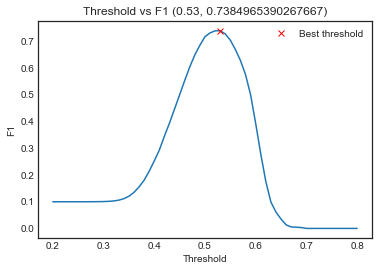

               mod   mean_f1
3       resnet_w65  0.749896
0          air_u67  0.749802
4   se_resnext_u29  0.749795
2   preresnet_u101  0.749701
28      resnet_u65  0.749323
23      resnet_u31  0.749167
29     resnet_u101  0.748908
25      resnet_u60  0.748766
27      resnet_u63  0.748616
26      resnet_u61  0.748532
21      resnet_q27  0.748337
1    preresnet_u67  0.748240
18         iv3_u12  0.748094
24      resnet_u56  0.747985
30   se_resnet_u50  0.747287
19        irv2_u12  0.747243
16         iv3_q12  0.747155
22      resnet_u25  0.746862
20      resnet_q26  0.746858
6         irv2_q10  0.746680
32          bni_u1  0.746596
17         iv3_u11  0.746517
7       resnet_q24  0.746300
9       resnet_q40  0.746144
14          bni_q0  0.746112
15          bni_q1  0.746044
33          bni_u2  0.745870
8       resnet_q25  0.745754
5          iv3_q11  0.745533
13  se_resnext_q28  0.744551
31         gap_u14  0.744430
12  se_resnext_q26  0.741910
11         nas_q11  0.741379
10         gap

<Figure size 432x288 with 0 Axes>

In [432]:
# tb = table(rez$index[1:bestStep])
# names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

# if (intercept!=0) {
#   tb["Intercept"] = intercept
# }

# print(tb[order(-tb)])
# print(single[order(-single[,2]),][1:min(nrow(single),40),])

# # plot hillclimbing
# ggplot(data=rez, aes(x=step, y=score)) + 
#   geom_line(size=.75) + geom_point()  


# replace empty predictions with class having max probability
def tmax1(vlsp, t):
    rez = (vlsp > t).astype(int)
    rezm = np.sum(rez,axis=1)
    z = np.where(rezm==0)[0]
    for i in z:
        rez[i,np.argmax(vlsp[i])] = 1
    return rez
        
# compute best threshold for computed ensemble
thresholds = np.linspace(0.2, 0.8, 61)
# thresholds = np.linspace(-2, 2, 41)
# thresholds = np.linspace(-0.2, 0.2, 41)

scores = np.array([f1_score(y, np.int32(bestEnsemble > threshold),
                        average='macro') for threshold in thresholds])

# scores = np.array([f1_score(y, tmax1(bestEnsemble, threshold),
#                         average='macro') for threshold in thresholds])


# ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold), \
#                                   pred_eps=pred_eps) for threshold in thresholds])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('score_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

single['mean_'+metric] = single.iloc[:,1:].mean(axis=1)
single.sort_values('mean_'+metric,ascending=False,inplace=True)
print(single.loc[:,['mod','mean_'+metric]])

In [433]:
print(y.shape)
yis = np.array([yi for yi in y if len(np.nonzero(yi)[0])==1 ])
print(yis.shape)
yism = np.mean(yis,axis=0)


(31072, 28)
(15126, 28)


(-0.028576243238916825, 0.4436122904074585)

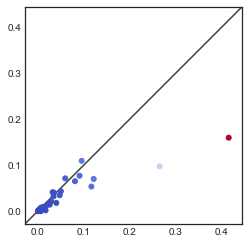

In [434]:
c = ymean**2 + yism**2

fig, ax = plt.subplots()
ax.scatter(ymean, yism, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against each other
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)



hillclimbing for class 0 Nucleoplasm

model 0 f1 0.8363 cut 0.5438 air_u67
model 1 f1 0.8355 cut 0.5442 preresnet_u67
model 2 f1 0.8371 cut 0.5420 preresnet_u101
model 3 f1 0.8315 cut 0.5527 resnet_w65
model 4 f1 0.8283 cut 0.5383 se_resnext_u29
model 5 f1 0.8240 cut 0.5637 iv3_q11
model 6 f1 0.8062 cut 0.5196 irv2_q10
model 7 f1 0.8133 cut 0.5175 resnet_q24
model 8 f1 0.8094 cut 0.5174 resnet_q25
model 9 f1 0.8066 cut 0.5191 resnet_q40
model 10 f1 0.8016 cut 0.5194 gap_q12
model 11 f1 0.7906 cut 0.4942 nas_q11
model 12 f1 0.7834 cut 0.4994 se_resnext_q26
model 13 f1 0.7989 cut 0.5057 se_resnext_q28
model 14 f1 0.7994 cut 0.5161 bni_q0
model 15 f1 0.8016 cut 0.5176 bni_q1
model 16 f1 0.8239 cut 0.5689 iv3_q12
model 17 f1 0.8149 cut 0.5186 iv3_u11
model 18 f1 0.8196 cut 0.5392 iv3_u12
model 19 f1 0.8233 cut 0.5473 irv2_u12
model 20 f1 0.7864 cut 0.4742 resnet_q26
model 21 f1 0.8220 cut 0.5212 resnet_q27
model 22 f1 0.8119 cut 0.5177 resnet_u25
model 23 f1 0.7987 cut 0.5084 resnet_u31


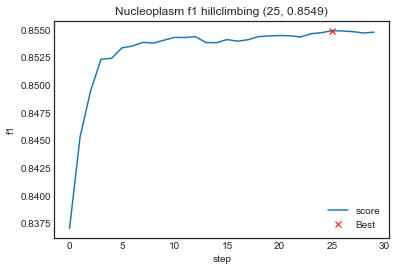

    step  midx     score             mod      f1_0
0      0     2  0.837056  preresnet_u101  0.837056
1      1     4  0.845305  se_resnext_u29  0.828341
2      2    21  0.849450      resnet_q27  0.821979
3      3    25  0.852337      resnet_u60  0.813495
4      4     0  0.852417         air_u67  0.836268
5      5     3  0.853369      resnet_w65  0.831547
6      6    21  0.853529      resnet_q27  0.821979
7      7     2  0.853860  preresnet_u101  0.837056
8      8     4  0.853799  se_resnext_u29  0.828341
9      9    21  0.854054      resnet_q27  0.821979
10    10     1  0.854311   preresnet_u67  0.835455
11    11    30  0.854297   se_resnet_u50  0.825350
12    12    30  0.854379   se_resnet_u50  0.825350
13    13     2  0.853844  preresnet_u101  0.837056
14    14    25  0.853831      resnet_u60  0.813495
15    15     0  0.854116         air_u67  0.836268
16    16     4  0.853965  se_resnext_u29  0.828341
17    17    21  0.854097      resnet_q27  0.821979
18    18    21  0.854378      r

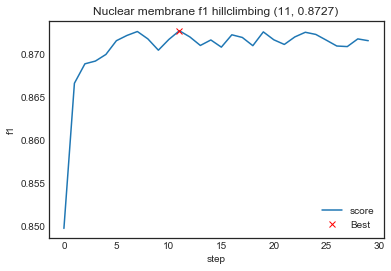

    step  midx     score             mod      f1_0
0      0    27  0.849796      resnet_u63  0.849796
1      1     4  0.866613  se_resnext_u29  0.843060
2      2    17  0.868866         iv3_u11  0.831596
3      3     3  0.869185      resnet_w65  0.835113
4      4     4  0.869952  se_resnext_u29  0.843060
5      5    27  0.871545      resnet_u63  0.849796
6      6     4  0.872150  se_resnext_u29  0.843060
7      7    14  0.872609          bni_q0  0.806503
8      8    17  0.871753         iv3_u11  0.831596
9      9    27  0.870445      resnet_u63  0.849796
10    10     4  0.871690  se_resnext_u29  0.843060
11    11    18  0.872698         iv3_u12  0.834532

      weight             mod      f1_0
midx                                  
3          1      resnet_w65  0.835113
4          4  se_resnext_u29  0.843060
14         1          bni_q0  0.806503
17         2         iv3_u11  0.831596
18         1         iv3_u12  0.834532
27         3      resnet_u63  0.849796


hillclimbing for class

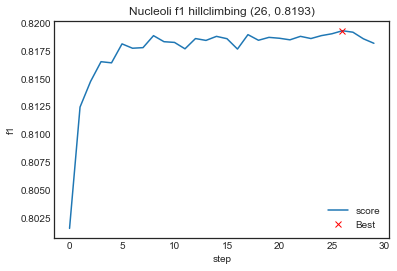

    step  midx     score             mod      f1_0
0      0     3  0.801565      resnet_w65  0.801565
1      1    21  0.812457      resnet_q27  0.748578
2      2     0  0.814752         air_u67  0.793601
3      3     2  0.816529  preresnet_u101  0.797732
4      4    21  0.816427      resnet_q27  0.748578
5      5     3  0.818129      resnet_w65  0.801565
6      6     0  0.817738         air_u67  0.793601
7      7     3  0.817792      resnet_w65  0.801565
8      8     6  0.818866        irv2_q10  0.747411
9      9     3  0.818325      resnet_w65  0.801565
10    10     9  0.818260      resnet_q40  0.728931
11    11     0  0.817686         air_u67  0.793601
12    12     1  0.818607   preresnet_u67  0.788220
13    13     0  0.818441         air_u67  0.793601
14    14     3  0.818803      resnet_w65  0.801565
15    15     9  0.818594      resnet_q40  0.728931
16    16     0  0.817664         air_u67  0.793601
17    17     3  0.818958      resnet_w65  0.801565
18    18     3  0.818454      r

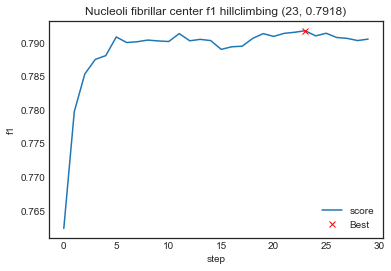

    step  midx     score             mod      f1_0
0      0     3  0.762386      resnet_w65  0.762386
1      1     4  0.779748  se_resnext_u29  0.711615
2      2     1  0.785340   preresnet_u67  0.757453
3      3    26  0.787512      resnet_u61  0.733705
4      4     3  0.788077      resnet_w65  0.762386
5      5    19  0.790848        irv2_u12  0.681081
6      6     3  0.790019      resnet_w65  0.762386
7      7    26  0.790139      resnet_u61  0.733705
8      8    21  0.790385      resnet_q27  0.652389
9      9    26  0.790260      resnet_u61  0.733705
10    10     4  0.790171  se_resnext_u29  0.711615
11    11     2  0.791349  preresnet_u101  0.751625
12    12    26  0.790281      resnet_u61  0.733705
13    13     2  0.790491  preresnet_u101  0.751625
14    14    11  0.790312         nas_q11  0.376487
15    15     3  0.789003      resnet_w65  0.762386
16    16    19  0.789390        irv2_u12  0.681081
17    17    19  0.789474        irv2_u12  0.681081
18    18     4  0.790638  se_re

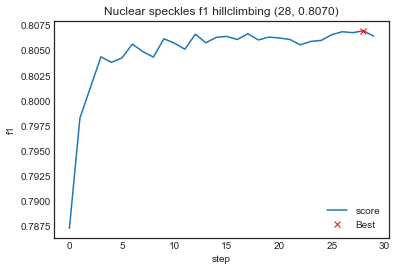

    step  midx     score             mod      f1_0
0      0     3  0.787275      resnet_w65  0.787275
1      1     0  0.798267         air_u67  0.776514
2      2     4  0.801321  se_resnext_u29  0.774833
3      3    26  0.804384      resnet_u61  0.751735
4      4     1  0.803830   preresnet_u67  0.779159
5      5    27  0.804265      resnet_u63  0.777990
6      6    25  0.805646      resnet_u60  0.754899
7      7    22  0.804898      resnet_u25  0.744395
8      8     1  0.804354   preresnet_u67  0.779159
9      9    27  0.806181      resnet_u63  0.777990
10    10    26  0.805744      resnet_u61  0.751735
11    11     3  0.805138      resnet_w65  0.787275
12    12    23  0.806636      resnet_u31  0.726928
13    13     1  0.805775   preresnet_u67  0.779159
14    14    27  0.806328      resnet_u63  0.777990
15    15     0  0.806417         air_u67  0.776514
16    16    26  0.806100      resnet_u61  0.751735
17    17     4  0.806686  se_resnext_u29  0.774833
18    18     4  0.806059  se_re

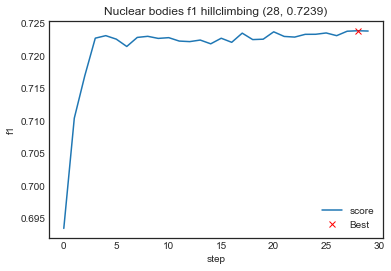

    step  midx     score             mod      f1_0
0      0     0  0.693443         air_u67  0.693443
1      1     3  0.710413      resnet_w65  0.688030
2      2     4  0.716950  se_resnext_u29  0.627589
3      3     2  0.722741  preresnet_u101  0.691217
4      4    25  0.723127      resnet_u60  0.682164
5      5    21  0.722592      resnet_q27  0.586758
6      6    26  0.721461      resnet_u61  0.669357
7      7    23  0.722855      resnet_u31  0.647579
8      8     3  0.723026      resnet_w65  0.688030
9      9     2  0.722704  preresnet_u101  0.691217
10    10    22  0.722819      resnet_u25  0.580324
11    11     0  0.722294         air_u67  0.693443
12    12    30  0.722210   se_resnet_u50  0.614277
13    13    25  0.722450      resnet_u60  0.682164
14    14    26  0.721870      resnet_u61  0.669357
15    15     4  0.722729  se_resnext_u29  0.627589
16    16     0  0.722103         air_u67  0.693443
17    17     3  0.723514      resnet_w65  0.688030
18    18    31  0.722522       

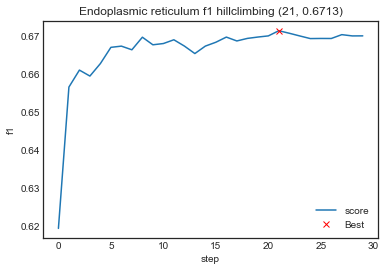

    step  midx     score             mod      f1_0
0      0     3  0.619407      resnet_w65  0.619407
1      1     4  0.656550  se_resnext_u29  0.618235
2      2     1  0.661009   preresnet_u67  0.596987
3      3    21  0.659440      resnet_q27  0.603448
4      4    21  0.662728      resnet_q27  0.603448
5      5     4  0.666987  se_resnext_u29  0.618235
6      6    21  0.667306      resnet_q27  0.603448
7      7     3  0.666345      resnet_w65  0.619407
8      8    19  0.669652        irv2_u12  0.600613
9      9    21  0.667657      resnet_q27  0.603448
10    10     4  0.667988  se_resnext_u29  0.618235
11    11    22  0.668976      resnet_u25  0.571429
12    12    21  0.667328      resnet_q27  0.603448
13    13     4  0.665356  se_resnext_u29  0.618235
14    14    19  0.667314        irv2_u12  0.600613
15    15    16  0.668327         iv3_q12  0.584964
16    16     7  0.669683      resnet_q24  0.568296
17    17     4  0.668666  se_resnext_u29  0.618235
18    18     1  0.669335   prer

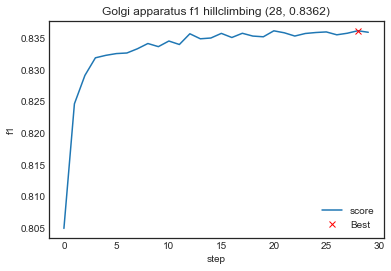

    step  midx     score             mod      f1_0
0      0     2  0.804896  preresnet_u101  0.804896
1      1     4  0.824645  se_resnext_u29  0.790215
2      2     0  0.829144         air_u67  0.804619
3      3     1  0.831933   preresnet_u67  0.804815
4      4    27  0.832328      resnet_u63  0.792705
5      5    23  0.832604      resnet_u31  0.774462
6      6     3  0.832696      resnet_w65  0.803770
7      7    30  0.833364   se_resnet_u50  0.785624
8      8    15  0.834199          bni_q1  0.746511
9      9    21  0.833705      resnet_q27  0.776294
10    10     3  0.834593      resnet_w65  0.803770
11    11    26  0.834044      resnet_u61  0.789049
12    12    30  0.835743   se_resnet_u50  0.785624
13    13    30  0.834948   se_resnet_u50  0.785624
14    14    26  0.835071      resnet_u61  0.789049
15    15    18  0.835804         iv3_u12  0.780183
16    16     0  0.835153         air_u67  0.804619
17    17     0  0.835821         air_u67  0.804619
18    18    18  0.835378       

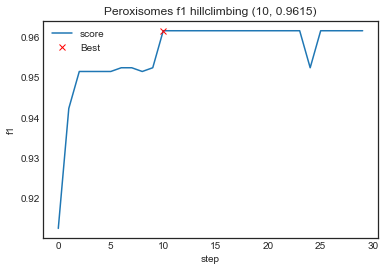

    step  midx     score             mod      f1_0
0      0     1  0.912621   preresnet_u67  0.912621
1      1     4  0.942308  se_resnext_u29  0.910891
2      2     3  0.951456      resnet_w65  0.886598
3      3     1  0.951456   preresnet_u67  0.912621
4      4     3  0.951456      resnet_w65  0.886598
5      5     4  0.951456  se_resnext_u29  0.910891
6      6    25  0.952381      resnet_u60  0.868687
7      7     8  0.952381      resnet_q25  0.811321
8      8    11  0.951456         nas_q11  0.648649
9      9    30  0.952381   se_resnet_u50  0.854167
10    10    10  0.961538         gap_q12  0.747664

      weight             mod      f1_0
midx                                  
1          2   preresnet_u67  0.912621
3          2      resnet_w65  0.886598
4          2  se_resnext_u29  0.910891
8          1      resnet_q25  0.811321
10         1         gap_q12  0.747664
11         1         nas_q11  0.648649
25         1      resnet_u60  0.868687
30         1   se_resnet_u50  0.8541

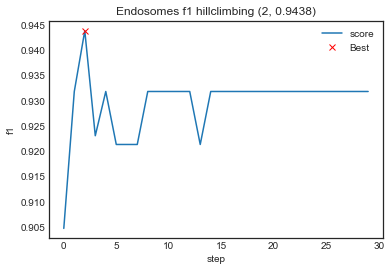

   step  midx     score             mod      f1_0
0     0     2  0.904762  preresnet_u101  0.904762
1     1     0  0.931818         air_u67  0.853659
2     2     3  0.943820      resnet_w65  0.878049

      weight             mod      f1_0
midx                                  
0          1         air_u67  0.853659
2          1  preresnet_u101  0.904762
3          1      resnet_w65  0.878049


hillclimbing for class 10 Lysosomes

model 0 f1 0.8679 cut 0.5472 air_u67
model 1 f1 0.8846 cut 0.5240 preresnet_u67
model 2 f1 0.9286 cut 0.5367 preresnet_u101
model 3 f1 0.9091 cut 0.5273 resnet_w65
model 4 f1 0.8800 cut 0.5105 se_resnext_u29
model 5 f1 0.6400 cut 0.4946 iv3_q11
model 6 f1 0.6786 cut 0.4768 irv2_q10
model 7 f1 0.6154 cut 0.4561 resnet_q24
model 8 f1 0.5429 cut 0.4525 resnet_q25
model 9 f1 0.5185 cut 0.4495 resnet_q40
model 10 f1 0.6512 cut 0.5472 gap_q12
model 11 f1 0.5263 cut 0.4787 nas_q11
model 12 f1 0.5500 cut 0.5421 se_resnext_q26
model 13 f1 0.5574 cut 0.4528 se_resnext_

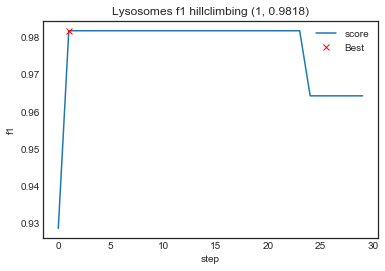

   step  midx     score             mod      f1_0
0     0     2  0.928571  preresnet_u101  0.928571
1     1     6  0.981818        irv2_q10  0.678571

      weight             mod      f1_0
midx                                  
2          1  preresnet_u101  0.928571
6          1        irv2_q10  0.678571


hillclimbing for class 11 Intermediate filaments

model 0 f1 0.7550 cut 0.5503 air_u67
model 1 f1 0.7510 cut 0.5633 preresnet_u67
model 2 f1 0.7561 cut 0.5532 preresnet_u101
model 3 f1 0.7566 cut 0.5544 resnet_w65
model 4 f1 0.7561 cut 0.5091 se_resnext_u29
model 5 f1 0.7348 cut 0.5810 iv3_q11
model 6 f1 0.7158 cut 0.5185 irv2_q10
model 7 f1 0.7248 cut 0.5115 resnet_q24
model 8 f1 0.6882 cut 0.5236 resnet_q25
model 9 f1 0.7252 cut 0.5063 resnet_q40
model 10 f1 0.7139 cut 0.5782 gap_q12
model 11 f1 0.5888 cut 0.4922 nas_q11
model 12 f1 0.6815 cut 0.5625 se_resnext_q26
model 13 f1 0.7032 cut 0.5578 se_resnext_q28
model 14 f1 0.7025 cut 0.5182 bni_q0
model 15 f1 0.6915 cut 0.5231 bni_q

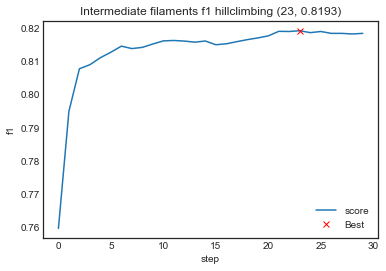

    step  midx     score             mod      f1_0
0      0    19  0.759579        irv2_u12  0.759579
1      1     3  0.794959      resnet_w65  0.756579
2      2    13  0.807802  se_resnext_q28  0.703205
3      3    26  0.809031      resnet_u61  0.711447
4      4     4  0.811148  se_resnext_u29  0.756109
5      5    21  0.812803      resnet_q27  0.706280
6      6     5  0.814636         iv3_q11  0.734752
7      7    30  0.813898   se_resnet_u50  0.755725
8      8    19  0.814272        irv2_u12  0.759579
9      9    28  0.815287      resnet_u65  0.757764
10    10    21  0.816227      resnet_q27  0.706280
11    11    26  0.816346      resnet_u61  0.711447
12    12    20  0.816169      resnet_q26  0.658627
13    13    18  0.815840         iv3_u12  0.751618
14    14    17  0.816190         iv3_u11  0.727104
15    15    19  0.815062        irv2_u12  0.759579
16    16     0  0.815348         air_u67  0.755035
17    17    28  0.815992      resnet_u65  0.757764
18    18     4  0.816602  se_re

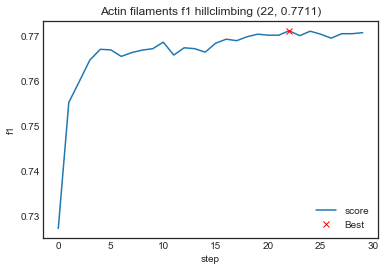

    step  midx     score             mod      f1_0
0      0     4  0.727273  se_resnext_u29  0.727273
1      1    19  0.755193        irv2_u12  0.716105
2      2     1  0.759846   preresnet_u67  0.707813
3      3    17  0.764576         iv3_u11  0.673668
4      4    30  0.766983   se_resnet_u50  0.691869
5      5     1  0.766862   preresnet_u67  0.707813
6      6     3  0.765415      resnet_w65  0.707715
7      7    22  0.766262      resnet_u25  0.670134
8      8     4  0.766810  se_resnext_u29  0.727273
9      9     7  0.767123      resnet_q24  0.690549
10    10    17  0.768571         iv3_u11  0.673668
11    11    30  0.765714   se_resnet_u50  0.691869
12    12     1  0.767323   preresnet_u67  0.707813
13    13    27  0.767123      resnet_u63  0.705388
14    14     3  0.766355      resnet_w65  0.707715
15    15    19  0.768345        irv2_u12  0.716105
16    16    17  0.769231         iv3_u11  0.673668
17    17     1  0.768898   preresnet_u67  0.707813
18    18    30  0.769784   se_r

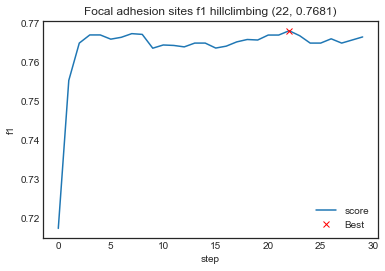

    step  midx     score             mod      f1_0
0      0     3  0.717391      resnet_w65  0.717391
1      1     4  0.755374  se_resnext_u29  0.695198
2      2     1  0.764948   preresnet_u67  0.714579
3      3    30  0.767040   se_resnet_u50  0.665298
4      4     3  0.767040      resnet_w65  0.717391
5      5     1  0.765957   preresnet_u67  0.714579
6      6     3  0.766431      resnet_w65  0.717391
7      7    29  0.767372     resnet_u101  0.676190
8      8     0  0.767179         air_u67  0.700518
9      9     3  0.763636      resnet_w65  0.717391
10    10     1  0.764463   preresnet_u67  0.714579
11    11    29  0.764344     resnet_u101  0.676190
12    12    19  0.763975        irv2_u12  0.685656
13    13    19  0.764948        irv2_u12  0.685656
14    14    17  0.764948         iv3_u11  0.596050
15    15     1  0.763674   preresnet_u67  0.714579
16    16     3  0.764161      resnet_w65  0.717391
17    17     4  0.765253  se_resnext_u29  0.695198
18    18     4  0.765869  se_re

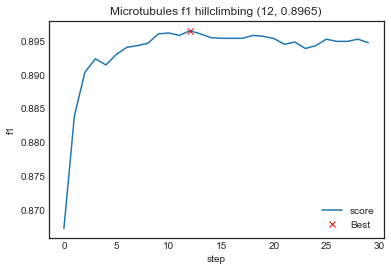

    step  midx     score             mod      f1_0
0      0    13  0.867265  se_resnext_q28  0.867265
1      1     3  0.883920      resnet_w65  0.840930
2      2     2  0.890347  preresnet_u101  0.858464
3      3     5  0.892337         iv3_q11  0.856197
4      4     4  0.891429  se_resnext_u29  0.859135
5      5    33  0.892992          bni_u2  0.865728
6      6    21  0.894040      resnet_q27  0.862857
7      7    24  0.894286      resnet_u56  0.859953
8      8    33  0.894636          bni_u2  0.865728
9      9     3  0.896023      resnet_w65  0.840930
10    10     4  0.896154  se_resnext_u29  0.859135
11    11    33  0.895793          bni_u2  0.865728
12    12    24  0.896485      resnet_u56  0.859953

      weight             mod      f1_0
midx                                  
2          1  preresnet_u101  0.858464
3          2      resnet_w65  0.840930
4          2  se_resnext_u29  0.859135
5          1         iv3_q11  0.856197
13         1  se_resnext_q28  0.867265
21         1

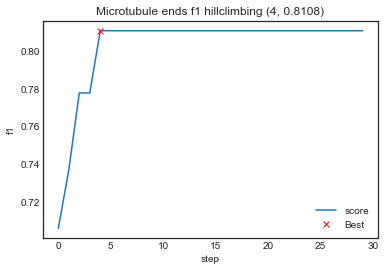

   step  midx     score             mod      f1_0
0     0    16  0.705882         iv3_q12  0.705882
1     1     1  0.736842   preresnet_u67  0.685714
2     2    23  0.777778      resnet_u31  0.666667
3     3    13  0.777778  se_resnext_q28  0.562500
4     4    19  0.810811        irv2_u12  0.580645

      weight             mod      f1_0
midx                                  
1          1   preresnet_u67  0.685714
13         1  se_resnext_q28  0.562500
16         1         iv3_q12  0.705882
19         1        irv2_u12  0.580645
23         1      resnet_u31  0.666667


hillclimbing for class 16 Cytokinetic bridge

model 0 f1 0.4486 cut 0.5591 air_u67
model 1 f1 0.4287 cut 0.5461 preresnet_u67
model 2 f1 0.4333 cut 0.5543 preresnet_u101
model 3 f1 0.4648 cut 0.5700 resnet_w65
model 4 f1 0.4561 cut 0.5177 se_resnext_u29
model 5 f1 0.4096 cut 0.5862 iv3_q11
model 6 f1 0.3588 cut 0.5359 irv2_q10
model 7 f1 0.3352 cut 0.5275 resnet_q24
model 8 f1 0.3216 cut 0.5338 resnet_q25
model 9 f1 0.28

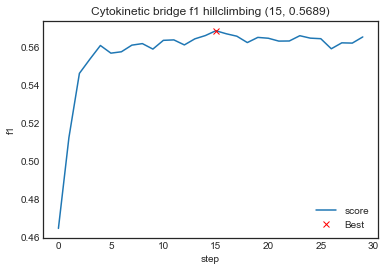

    step  midx     score             mod      f1_0
0      0     3  0.464774      resnet_w65  0.464774
1      1     4  0.512586  se_resnext_u29  0.456140
2      2    16  0.546425         iv3_q12  0.448718
3      3    26  0.553911      resnet_u61  0.374728
4      4    30  0.561105   se_resnet_u50  0.363095
5      5    18  0.557068         iv3_u12  0.421160
6      6     4  0.557794  se_resnext_u29  0.456140
7      7    27  0.561290      resnet_u63  0.438095
8      8    32  0.562092          bni_u1  0.313433
9      9    16  0.559211         iv3_q12  0.448718
10    10    30  0.563818   se_resnet_u50  0.363095
11    11     2  0.564047  preresnet_u101  0.433300
12    12    21  0.561404      resnet_q27  0.407115
13    13     4  0.564604  se_resnext_u29  0.456140
14    14    12  0.566332  se_resnext_q26  0.323314
15    15    16  0.568869         iv3_q12  0.448718

      weight             mod      f1_0
midx                                  
2          1  preresnet_u101  0.433300
3          1   

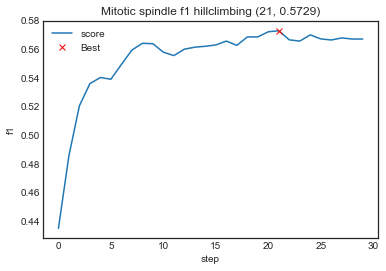

    step  midx     score            mod      f1_0
0      0     1  0.435013  preresnet_u67  0.435013
1      1    16  0.485714        iv3_q12  0.410000
2      2    24  0.520548     resnet_u56  0.423256
3      3    25  0.535980     resnet_u60  0.365854
4      4    22  0.540260     resnet_u25  0.391579
5      5    21  0.539043     resnet_q27  0.432314
6      6     9  0.549333     resnet_q40  0.355289
7      7    21  0.559367     resnet_q27  0.432314
8      8    21  0.564103     resnet_q27  0.432314
9      9    15  0.563830         bni_q1  0.319739
10    10    21  0.557895     resnet_q27  0.432314
11    11    15  0.555556         bni_q1  0.319739
12    12    25  0.560000     resnet_u60  0.365854
13    13    20  0.561404     resnet_q26  0.386179
14    14    21  0.562025     resnet_q27  0.432314
15    15    21  0.562963     resnet_q27  0.432314
16    16    23  0.565657     resnet_u31  0.336245
17    17    30  0.562660  se_resnet_u50  0.335601
18    18     8  0.568528     resnet_q25  0.389722


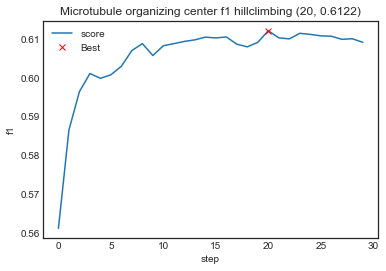

    step  midx     score             mod      f1_0
0      0     1  0.561120   preresnet_u67  0.561120
1      1    21  0.586533      resnet_q27  0.547903
2      2    25  0.596431      resnet_u60  0.514408
3      3    20  0.601130      resnet_q26  0.513955
4      4    21  0.599886      resnet_q27  0.547903
5      5    23  0.600800      resnet_u31  0.495248
6      6     4  0.603015  se_resnext_u29  0.524590
7      7     1  0.607062   preresnet_u67  0.561120
8      8    28  0.608844      resnet_u65  0.509600
9      9    21  0.605780      resnet_q27  0.547903
10    10    25  0.608305      resnet_u60  0.514408
11    11    21  0.608844      resnet_q27  0.547903
12    12    25  0.609418      resnet_u60  0.514408
13    13     1  0.609825   preresnet_u67  0.561120
14    14    23  0.610526      resnet_u31  0.495248
15    15    16  0.610318         iv3_q12  0.475616
16    16     3  0.610574      resnet_w65  0.519553
17    17    14  0.608696          bni_q0  0.480800
18    18     0  0.608018       

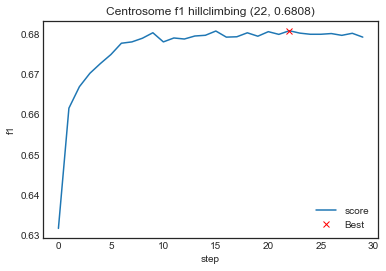

    step  midx     score             mod      f1_0
0      0    28  0.631724      resnet_u65  0.631724
1      1    26  0.661569      resnet_u61  0.627207
2      2     4  0.666896  se_resnext_u29  0.575530
3      3    21  0.670224      resnet_q27  0.558743
4      4     0  0.672640         air_u67  0.617276
5      5    26  0.674872      resnet_u61  0.627207
6      6    16  0.677680         iv3_q12  0.569965
7      7     1  0.678011   preresnet_u67  0.616869
8      8    28  0.678917      resnet_u65  0.631724
9      9     9  0.680281      resnet_q40  0.519292
10    10    17  0.678011         iv3_u11  0.559606
11    11    28  0.678984      resnet_u65  0.631724
12    12    19  0.678727        irv2_u12  0.561648
13    13    26  0.679474      resnet_u61  0.627207
14    14    21  0.679651      resnet_q27  0.558743
15    15    26  0.680709      resnet_u61  0.627207
16    16    17  0.679195         iv3_u11  0.559606
17    17    28  0.679284      resnet_u65  0.631724
18    18     1  0.680268   prer

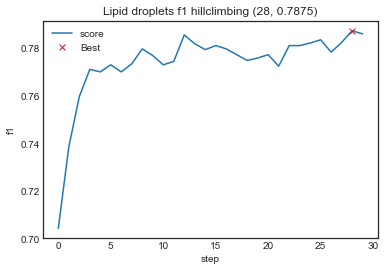

    step  midx     score             mod      f1_0
0      0     4  0.704319  se_resnext_u29  0.704319
1      1     0  0.738562         air_u67  0.634006
2      2     3  0.759740      resnet_w65  0.640483
3      3    20  0.771242      resnet_q26  0.550820
4      4    18  0.770186         iv3_u12  0.631229
5      5    20  0.773163      resnet_q26  0.550820
6      6    23  0.770186      resnet_u31  0.591900
7      7     4  0.773585  se_resnext_u29  0.704319
8      8    14  0.779874          bni_q0  0.537396
9      9    21  0.777070      resnet_q27  0.532637
10    10    26  0.773163      resnet_u61  0.552632
11    11     4  0.774603  se_resnext_u29  0.704319
12    12    21  0.785714      resnet_q27  0.532637
13    13     1  0.782051   preresnet_u67  0.617211
14    14     0  0.779553         air_u67  0.634006
15    15    18  0.781250         iv3_u12  0.631229
16    16    20  0.779874      resnet_q26  0.550820
17    17    20  0.777429      resnet_q26  0.550820
18    18     1  0.775000   prer

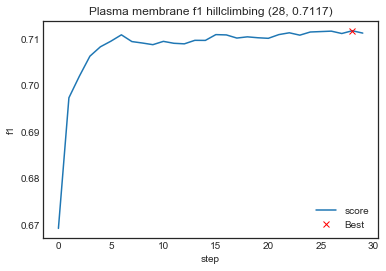

    step  midx     score             mod      f1_0
0      0     3  0.669235      resnet_w65  0.669235
1      1    16  0.697321         iv3_q12  0.660671
2      2     4  0.701973  se_resnext_u29  0.666330
3      3    19  0.706257        irv2_u12  0.663680
4      4     0  0.708279         air_u67  0.662584
5      5     1  0.709485   preresnet_u67  0.663605
6      6    31  0.710851         gap_u14  0.631922
7      7    21  0.709401      resnet_q27  0.658920
8      8    30  0.709091   se_resnet_u50  0.638865
9      9    21  0.708735      resnet_q27  0.658920
10    10    23  0.709446      resnet_u31  0.621434
11    11    32  0.709033          bni_u1  0.658512
12    12    18  0.708913         iv3_u12  0.660253
13    13     4  0.709669  se_resnext_u29  0.666330
14    14     2  0.709653  preresnet_u101  0.655113
15    15    27  0.710896      resnet_u63  0.665414
16    16     9  0.710833      resnet_q40  0.650172
17    17     4  0.710156  se_resnext_u29  0.666330
18    18    18  0.710419       

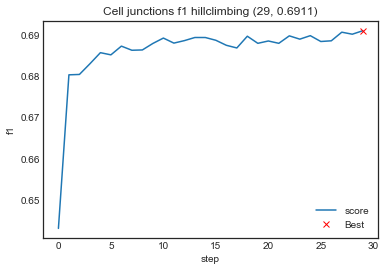

    step  midx     score             mod      f1_0
0      0     4  0.643100  se_resnext_u29  0.643100
1      1     3  0.680374      resnet_w65  0.638083
2      2    19  0.680466        irv2_u12  0.605201
3      3     0  0.683053         air_u67  0.611550
4      4     4  0.685751  se_resnext_u29  0.643100
5      5    27  0.685222      resnet_u63  0.629676
6      6    28  0.687339      resnet_u65  0.622990
7      7     4  0.686337  se_resnext_u29  0.643100
8      8     0  0.686413         air_u67  0.611550
9      9     3  0.687990      resnet_w65  0.638083
10    10     4  0.689295  se_resnext_u29  0.643100
11    11     0  0.688073         air_u67  0.611550
12    12     4  0.688673  se_resnext_u29  0.643100
13    13     2  0.689433  preresnet_u101  0.621656
14    14     4  0.689429  se_resnext_u29  0.643100
15    15     2  0.688759  preresnet_u101  0.621656
16    16    22  0.687541      resnet_u25  0.589217
17    17    18  0.686895         iv3_u12  0.592686
18    18    18  0.689744       

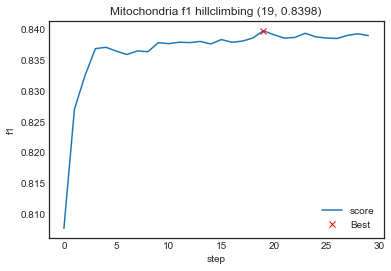

    step  midx     score             mod      f1_0
0      0     4  0.807686  se_resnext_u29  0.807686
1      1     0  0.827021         air_u67  0.802603
2      2     3  0.832440      resnet_w65  0.796133
3      3    23  0.836857      resnet_u31  0.783793
4      4    19  0.837073        irv2_u12  0.794713
5      5     6  0.836451        irv2_q10  0.780572
6      6     3  0.835908      resnet_w65  0.796133
7      7    30  0.836481   se_resnet_u50  0.798793
8      8     4  0.836357  se_resnext_u29  0.807686
9      9     3  0.837824      resnet_w65  0.796133
10    10    21  0.837666      resnet_q27  0.793827
11    11     0  0.837903         air_u67  0.802603
12    12    26  0.837833      resnet_u61  0.783244
13    13    23  0.838020      resnet_u31  0.783793
14    14     3  0.837621      resnet_w65  0.796133
15    15     4  0.838332  se_resnext_u29  0.807686
16    16    19  0.837893        irv2_u12  0.794713
17    17     3  0.838079      resnet_w65  0.796133
18    18     4  0.838577  se_re

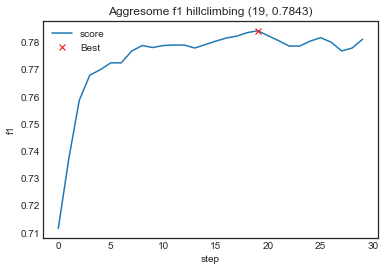

    step  midx     score            mod      f1_0
0      0    18  0.711599        iv3_u12  0.711599
1      1     0  0.737190        air_u67  0.674576
2      2    25  0.758735     resnet_u60  0.677368
3      3    26  0.767974     resnet_u61  0.693038
4      4     5  0.769984        iv3_q11  0.687285
5      5    26  0.772504     resnet_u61  0.693038
6      6     0  0.772504        air_u67  0.674576
7      7    26  0.776860     resnet_u61  0.693038
8      8    23  0.778878     resnet_u31  0.604027
9      9    30  0.778146  se_resnet_u50  0.681745
10    10    28  0.778878     resnet_u65  0.689984
11    11     6  0.779051       irv2_q10  0.639344
12    12    30  0.779051  se_resnet_u50  0.681745
13    13     3  0.777958     resnet_w65  0.681115
14    14     1  0.779221  preresnet_u67  0.702163
15    15    11  0.780488        nas_q11  0.577086
16    16     3  0.781609     resnet_w65  0.681115
17    17     0  0.782324        air_u67  0.674576
18    18     8  0.783607     resnet_q25  0.640123


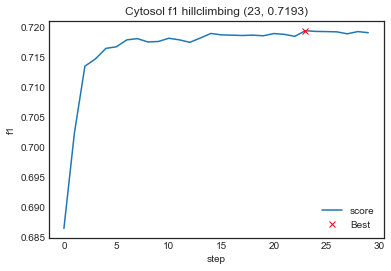

    step  midx     score             mod      f1_0
0      0    21  0.686423      resnet_q27  0.686423
1      1    25  0.702314      resnet_u60  0.666161
2      2    16  0.713446         iv3_q12  0.684675
3      3     4  0.714652  se_resnext_u29  0.678585
4      4     3  0.716411      resnet_w65  0.681450
5      5    27  0.716682      resnet_u63  0.678145
6      6     2  0.717832  preresnet_u101  0.678134
7      7    21  0.718035      resnet_q27  0.686423
8      8    16  0.717486         iv3_q12  0.684675
9      9    23  0.717561      resnet_u31  0.676512
10    10     2  0.718100  preresnet_u101  0.678134
11    11    25  0.717832      resnet_u60  0.666161
12    12    27  0.717423      resnet_u63  0.678145
13    13     4  0.718138  se_resnext_u29  0.678585
14    14    25  0.718901      resnet_u60  0.666161
15    15     0  0.718660         air_u67  0.680583
16    16    16  0.718617         iv3_q12  0.684675
17    17    19  0.718558        irv2_u12  0.675564
18    18     4  0.718620  se_re

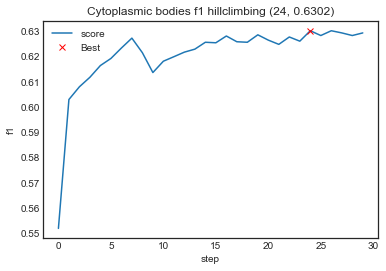

    step  midx     score             mod      f1_0
0      0     3  0.551938      resnet_w65  0.551938
1      1    30  0.602965   se_resnet_u50  0.465753
2      2    23  0.608000      resnet_u31  0.493789
3      3    19  0.611765        irv2_u12  0.511494
4      4     3  0.616415      resnet_w65  0.551938
5      5    14  0.619205          bni_q0  0.423729
6      6    25  0.623333      resnet_u60  0.427762
7      7    14  0.627258          bni_q0  0.423729
8      8    21  0.621488      resnet_q27  0.472180
9      9     0  0.613636         air_u67  0.547085
10    10    30  0.618123   se_resnet_u50  0.465753
11    11    30  0.619902   se_resnet_u50  0.465753
12    12     3  0.621711      resnet_w65  0.551938
13    13     3  0.622896      resnet_w65  0.551938
14    14    19  0.625624        irv2_u12  0.511494
15    15     1  0.625418   preresnet_u67  0.522796
16    16    30  0.628099   se_resnet_u50  0.465753
17    17    29  0.625828     resnet_u101  0.490818
18    18    26  0.625624      r

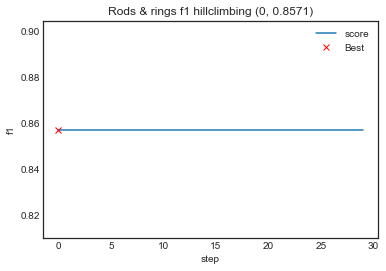

   step  midx     score      mod      f1_0
0     0     0  0.857143  air_u67  0.857143

      weight      mod      f1_0
midx                           
0          1  air_u67  0.857143

overall mean f1 0.778065888327282  mean cut 0.5232633098795911   mean steps 19.071428571428573


<Figure size 432x288 with 0 Axes>

In [435]:
# hillclimbing separately for each class

# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))
nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0

metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)

# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc','f1']
bestCut = threshold

num_classes = 28

rez_all = []
tb_all = []
bestEnsemble_all = []
bestStep_all = []
bestScore_all = []
bestCut_all = []

for c in range(num_classes):
    
    print()
    print()
    print('hillclimbing for class',c,LABEL_MAP[c])
    print()

    rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                        'score':np.zeros(nstep)})
    currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

    # maximizing
    bestScore = -9999999
    single = pd.DataFrame({'mod':np.repeat("",nm)})
    start = 0
    for step in range(start,nstep):
        single[metric+'_'+str(step)] = np.nan

    for step in range(start,nstep):
        currIndex = 0
        currScore = -9999999

        for i in range(nm):

            mname = vp.columns[i+offset]

            tv = np.array(list(vp.iloc[:,offset+i].values))

            # mean-center
    #         tv = tv - np.mean(tv)

            # adjust by model-specific threshold
    #         tv = tv - mthresh[mname]

            # adjust by model-class-specific thresholds
    #         for j in range(tv.shape[1]):
    #             tv[:,j] = tv[:,j] - cthresh[mname][j]

            if np.sum(np.isnan(tv)) > 0: continue

            if step==0:
                tryEnsemble = tv
            else:
                # running mean
                tryEnsemble = (step * currEnsemble + tv)/(step+1)
                # full matrix
                # choose median or mean here
                # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                # quantiles are a lot slower
                # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

            if metric=="f1":
                # estimate new class-specific thresholds by line search, slow
                cut = fit_val1(tryEnsemble[:,c],y[:,c])
                tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > cut))

#                 # estimate new class-specific thresholds to match proportions, medium
#                 th = fit_val2(tryEnsemble[:,c],y[:,c])
#                 tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > th))

#                 # fixed threshold, fast
#                 tryScore = f1_score(y[:,c], np.int32(tryEnsemble[:,c] > threshold))

#                 if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
            elif metric=="iou":
                tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                            pred_eps=pred_eps)
                if step > 0: print('    try',i,mname,"%6.4f" % tryScore)
            elif metric=="mse":
                tryScore = -mse(y,tryEnsemble)
            elif metric=="mae": 
                tryScore = -mae(y,tryEnsemble)
            elif metric=="winsorized_mae": 
                tryScore = -winsorized_mae(y,tryEnsemble+intercept)
            elif metric=="rmse":
                tryScore = -rmse(y,tryEnsemble)
            elif metric=="corr":
                tryScore = cor(y,tryEnsemble)
            elif metric=="mcc":
                opt = eval_mcc3(y,tryEnsemble,cut=T)
                tryScore = opt[1]
                cut = opt[2]
                # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                # tryScore = opt$objective
            elif metric=="logloss":
                # tryScore = -logLoss(vp$y,tryEnsemble,)
                tryScore = -eval_logloss2(tryEnsemble,y)
            elif metric=="auc":
                tryScore = auc2(y,tryEnsemble)
            elif metric=="auprc":
                tryScore = auprc(tryEnsemble, y)
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
            elif metric=="aurocpr":
                auroc = auc(y,tryEnsemble)
                # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                tryScore = (auroc + auprc)/2
            elif metric=="sqwk":
                tryScore = sqwk(y,tryEnsemble,1,8)

            ok = 1
            if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
            if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

            if (tryScore > currScore) and (ok==1):
                currIndex = i
                currScore = tryScore
                if (step==0):
                    saveEnsemble = tv.copy()
                else:
                    # running mean
                    saveEnsemble = tryEnsemble.copy()
                    # save whole matrix
                    # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                if metric in cut_mets: currCut = cut

            # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
            if (step==0):
                if metric in cut_mets:
                    print("model",i,metric,"%6.4f" % tryScore,
                          "cut %6.4f" % cut, vp.columns[i+offset])
                else:
                    print("model",i,metric,"%6.4f" % tryScore, vp.columns[i+offset])

            if step==0:
                single.loc[i,'mod'] = vp.columns[i+offset]  
            single.iloc[i,step+1] = tryScore

        if metric in cut_mets:
            print("step =", step,"  ", metric,"= %6.4f" % currScore,
                  "  cut = %6.4f" % currCut,"  name =", vp.columns[currIndex+offset])
        else:
            print("step =",step,"  ", metric,"= %6.4f" % currScore,
                  "  name =", vp.columns[currIndex+offset])

        currEnsemble = saveEnsemble.copy()
        if currScore > bestScore:
            bestScore = currScore
            bestStep = step
            bestEnsemble = currEnsemble.copy()
            if metric in cut_mets: bestCut = currCut

        rez.iloc[step,0] = step
        rez.iloc[step,1] = currIndex
        rez.iloc[step,2] = currScore

    if metric in cut_mets:
        print("best step =",bestStep,"  best",metric,"= %6.4f" % bestScore,
              "  best cut = %6.4f" % bestCut)
    else:
        print("best step =",bestStep,"  best",metric,"= %6.4f" % bestScore)

    rez0 = rez.copy()

    # tb = table(rez$index[1:bestStep])
    # names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

    # if (intercept!=0) {
    #   tb["Intercept"] = intercept
    # }

    # print(tb[order(-tb)])
    # print(single[order(-single[,2]),][1:min(nrow(single),40),])

    # plot hillclimbing
    print('')
    plt.plot(rez0.step, rez0.score)
    plt.plot(bestStep, bestScore, "xr", label="Best")
    plt.xlabel("step")
    plt.ylabel(metric)
    plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
    plt.legend()
    plt.show()
    plt.gcf().clear()

    # display the weights
    rez = rez.iloc[:(bestStep+1)]
    # print(rez)

    single0 = single.iloc[:,:2]

    rez['midx'] = rez['midx'].astype(int)
    rez = rez.join(single0,how='left',on='midx')
    print(rez)
    print('')

    rez['weight'] = 1
    tb = rez.loc[:,['midx','weight']].groupby('midx').count()
    # print(tb)
    # print(single)

    tb = tb.join(single0,how='left')
    print(tb)
    
    rez_all.append(rez)
    tb_all.append(tb)
    bestEnsemble_all.append(bestEnsemble)
    bestStep_all.append(bestStep)
    bestScore_all.append(bestScore)
    bestCut_all.append(bestCut)

print()
print('overall mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))

In [436]:
print('mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))

mean f1 0.778065888327282  mean cut 0.5232633098795911   mean steps 19.071428571428573


In [437]:
# tb_all

In [438]:
midx = str(midx)
fname = 'ens_weights'+midx+'.pkl'
pickle.dump(tb_all,open(fname,'wb'))
print(fname)

ens_weights66.pkl


In [439]:
for i in range(28):
    tb_all[i]['class'] = i
tba = pd.concat(tb_all).reset_index()
print(tba.shape)

(276, 5)


In [440]:
tba.head()

midx  weight             mod      f1_0  class
0     0       3         air_u67  0.836268      0
1     1       2   preresnet_u67  0.835455      0
2     2       4  preresnet_u101  0.837056      0
3     3       1      resnet_w65  0.831547      0
4     4       5  se_resnext_u29  0.828341      0

In [441]:
# show most popular models
tbag = tba.groupby('mod')
ws = pd.DataFrame(tbag['weight'].sum())
ws.columns = ['ws']
ws.sort_values(['ws'],ascending=False,inplace=True)
print(ws)

                ws
mod               
se_resnext_u29  72
resnet_w65      64
resnet_q27      48
air_u67         47
preresnet_u67   37
resnet_u61      30
se_resnet_u50   27
irv2_u12        27
preresnet_u101  26
resnet_u31      19
resnet_u63      18
resnet_u60      18
iv3_q12         17
resnet_u65      13
iv3_u12         12
iv3_u11          9
resnet_u25       9
resnet_q26       9
bni_q0           7
resnet_q40       6
bni_u2           5
resnet_q25       5
resnet_u101      4
resnet_u56       4
iv3_q11          4
irv2_q10         4
gap_q12          3
resnet_q24       3
nas_q11          3
bni_q1           3
gap_u14          3
se_resnext_q28   3
bni_u1           2
se_resnext_q26   1


In [442]:
bestCut_all

[0.5405092848021451,
 0.537439589718823,
 0.5293532289369124,
 0.5275226086916618,
 0.5330421651026224,
 0.530381519869996,
 0.5332671497037873,
 0.5243894059593378,
 0.4589017467192736,
 0.48371610308556434,
 0.472327665874664,
 0.531680805412073,
 0.5302023422551876,
 0.5345094458799645,
 0.5670132235848754,
 0.4762973488375031,
 0.5339713524448028,
 0.5140826482096075,
 0.5259560826558354,
 0.5308497416526466,
 0.5000334833938852,
 0.5252134165081072,
 0.538065981474227,
 0.5264241556470067,
 0.5330826134869735,
 0.5338226674118625,
 0.5320981031859051,
 0.547218796123302]

In [443]:
f1_score(y[:,9],y[:,10])

0.7671232876712328

In [444]:
confusion_matrix(y[:,9],y[:,10])

array([[31027,     0],
       [   17,    28]])

In [446]:
bestEnsemble_all[0].shape

(31072, 28)

In [448]:
vp.index.values[:5]

array(['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', '000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0', '001838f8-bbca-11e8-b2bc-ac1f6b6435d0'], dtype=object)

In [452]:
ens = np.zeros((vp.shape[0],num_classes))
for j in range(num_classes):
    ens[:,j] = bestEnsemble_all[j][:,j]
p = pd.DataFrame(ens)
p.columns = ['p'+str(i) for i in range(ens.shape[1])]
subp = pd.DataFrame({'id':vp.index.values,'data':'oof'})
subp = pd.concat((subp,p),axis=1)
print(subp.shape)
fname = 'oof/oof' + midx + '_probs.csv'
subp.to_csv(fname, index=False)
print(fname)

(31072, 30)
oof/oof66_probs.csv


In [445]:
########  OLD CODE BELOW HERE ###########

# best possible score
np.mean(np.max(ioua,axis=0))

NameError: name 'ioua' is not defined

In [ ]:
am = (am + am2) // 2
print(am.shape)
print(am[:50])

In [ ]:
train_df['best_thresh'] = [thresholds[a] for a in am]
train_df['pred_mean'] = [np.mean(b) for b in bestEnsemble]
train_df['pred_std'] = [np.std(b) for b in bestEnsemble]
train_df['pred_min'] = [np.min(b) for b in bestEnsemble]
train_df['pred_max'] = [np.max(b) for b in bestEnsemble]
train_df['image_mean'] = [np.mean(b) for b in train_df.images]
train_df['image_std'] = [np.std(b) for b in train_df.images]
print(train_df.shape)

In [ ]:
fname = 'best_thresh.csv'
train_df.to_csv(fname)
print(fname)

In [ ]:
# predict best threshold with bootstrap forest in jmp
btp = pd.read_csv('btp.csv')
# btp = pd.read_csv('btp2.csv')
print(btp.head())
print(btp.shape)

In [ ]:
btpa = btp.btp.values

In [ ]:
ioub = np.array([iou_metric(m, np.int32(b > (t + 0.1)), pred_eps=pred_eps) \
                 for m, b, t in zip(train_df.masks, bestEnsemble, btpa)])

print(np.mean(ioub))

In [ ]:
# threshold_best_index = np.argmax(ious[9:-10]) + 9
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('iou_best',iou_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
# compute best epsilon threshold for computed ensemble, still on logit scale
peps = np.array([1e-12, 0.00001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])
ious = np.array([iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best),
                                  pred_eps=e) for e in peps])

# threshold_best_index = np.argmax(ious[9:-10]) + 9
eps_best_index = np.argmax(ious)
iou_best = ious[eps_best_index]
eps_best = peps[eps_best_index]
print('')
print('iou_best',iou_best)
print('eps_best',eps_best)
print('')

plt.plot(peps, ious)
plt.plot(eps_best, iou_best, "xr", label="Best epsilon")
plt.xlabel("Epsilon")
plt.ylabel("IoU")
plt.title("IOU vs Prediction Epsilon ({}, {})".format(iou_best, eps_best))
plt.legend()
plt.show()
plt.gcf().clear()

In [ ]:
ious

In [ ]:
v = [(np.mean(mask),np.mean(pred)) for mask,pred in zip(train_df.masks,
        np.int32(bestEnsemble > threshold_best))]

In [ ]:
v0 = [(a,b) for a,b in v if a == 0.0 and b > 0.5]

In [ ]:
v0

In [ ]:
v[:20]

In [ ]:
# Error analysis
ioum, ioub = iou_metric_batch(train_df.masks, np.int32(bestEnsemble > threshold_best), \
                              pred_eps=eps_best, return_all=True)
ioub = np.array(ioub)
print(ioub.min(),ioub.mean(),ioub.max())

sns.distplot(ioub)
plt.title("Distribution of OOF IOU Scores")
plt.show()
plt.gcf().clear()

train_df['ens'] = [bestEnsemble[i] for i in range(poof.shape[0])]

train_df['ensb'] = [np.array(bestEnsemble[i] > threshold_best) for i in range(poof.shape[0])]

train_df['pcov'] = [np.array(bestEnsemble[i] > threshold_best).mean() for i in range(poof.shape[0])]

train_df['ioub'] = ioub
print(train_df.columns)
print(train_df.shape)

ct = train_df.loc[:,['z','coverage','coverage_class','ioub']]
print(ct.groupby('coverage_class').mean())
print(ct.groupby('ioub').mean())

# plot coverage
print('')
plt.plot(train_df.pcov, train_df.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('')
# plt.plot(train_df.pcov, train_df.ioub, 'ro')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

print('corr',train_df.loc[:,['ioub','coverage','pcov']].corr())

# plot validation images with scores
# sort from worst to best then by salt coverage
train_dfs = train_df.sort_values(['ioub','coverage','pcov'],ascending=[True,True,False])

start = 0
stop = 500
# grid_width = 10
# grid_height = int(max_images / grid_width)
# print(max_images,grid_height,grid_width)
ni = 10

# show worst fitting images
for j in range(int(start/10),int(stop/10)):
    jj = j*10
    fig, axs = plt.subplots(2, ni, figsize=(20,4))
    for i in range(ni):
        img = train_dfs.iloc[jj+i].images
        mask = train_dfs.iloc[jj+i].masks
        pred = train_dfs.iloc[jj+i].ensb
        iou = train_dfs.iloc[jj+i].ioub
        cov = train_dfs.iloc[jj+i].coverage
        pcov = train_dfs.iloc[jj+i].pcov
        axs[0][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(img, cmap="Greys")
        axs[1][i].imshow(mask, alpha=0.3, cmap="Greens")
        axs[1][i].imshow(pred, alpha=0.3, cmap="OrRd")
        axs[0][i].set_title(str(iou) + ' ' + str(np.round(cov,4)) + ' ' + str(np.round(pcov,4)))
    fig.suptitle("Top row: original, bottom row: true salt green, predicted red")
    plt.show()
    plt.gcf().clear()

In [ ]:
print('')
sns.regplot(train_df.pcov, train_df.ioub, lowess=True)
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("IOU")
plt.title("IOU vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()

In [ ]:
# offset = 3
# nm = oof.shape[1] - offset
# print(offset, oof.shape, nm)

# oof.head()

# np.array(list(oof.iloc[:,3])).shape

# # simple mean ensemble over all models
# first = True
# for i in range(offset,offset+nm):
#     print(i)
#     p = np.array(list(oof.iloc[:,i].values))/nm
#     if first: 
#         ens = p
#         first = False
#     else: ens += p
# print(ens.shape)

# sns.distplot(ens.flatten())
# plt.show()
# plt.gcf().clear()

In [ ]:
d3 = train_df.loc[:,['ioub','coverage','pcov']]
# print(d3.shape)
d3q = d3.query('(coverage == 0.0) & (pcov >= 1e-6)')
print(d3q.shape)
print(d3q.describe())
print(d3q)

In [ ]:
# print(d3.shape)
d0 = d3.query('(ioub == 0.0)')
print(d0.describe())
print(d0.shape)
# print(d0)

In [ ]:
# IOU = 0 values
print('')
plt.plot(d0.pcov, d0.coverage, 'ro')
plt.xlabel("Predicted Salt Coverage")
plt.ylabel("Observed Salt Coverage")
plt.title("IOU = 0, Observed vs Predicted Salt Coverage")
plt.show()
plt.gcf().clear()


In [ ]:
ens = np.int32(bestEnsemble > threshold_best)
iou_metric_batch(train_df.masks, ens, pred_eps=eps_best)

In [ ]:
# average pixel accuracy
ens_cut = []
for e in ens:
    cov = np.mean(e)
    if cov <= pred_eps: e *= 0
    ens_cut.append(e)
    
acc = [np.mean(gt == e) for (gt,e) in zip(train_df.masks,ens_cut)]
print(np.mean(acc))

In [ ]:
# binary cross entropy
from scipy.special import expit
ce = [-np.mean((gt < 0.5)*np.log(1.0 - expit(e)) + (gt > 0.5)*np.log(expit(e))) \
      for (gt,e) in zip(train_df.masks,bestEnsemble)]
print(np.mean(ce))

In [ ]:
np.sum(bestEnsemble > 10.)

In [ ]:
# show max logits for each model, jackie becomes inf with eps <= 1e-4, np.clip does not work on upper bound
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
for c in mcols:
    print(c,np.array([m.max() for m in oof[c]]).max())

In [ ]:
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    # if str(df.loc[i,'rle_mask'])!=str(np.nan):        
    if True:        
        # decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        # plt.imshow(decoded_mask)
        plt.imshow(ens[i])
        plt.title('ID: '+train_df.index.values[i])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [ ]:
# crf kaggle kernel
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     # Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    # Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    # Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [ ]:
ens_crf = []
for i in range(train_df.shape[0]):
    ens_crf.append(crf(train_df.masks[i],ens[i]))
    if i % 1000 == 0: print(i)
ens_crf = np.array(ens_crf)  

In [ ]:
iou_metric_batch(train_df.masks,ens_crf,pred_eps=eps_best)

In [ ]:
print(tb)

In [ ]:
oof.shape

In [ ]:
oof.columns

In [ ]:
folds = pd.read_csv('folds.csv')
print(folds.head())
print(folds.shape)

In [ ]:
oof = oof.join(folds.set_index('id'),how='left')
print(oof.columns)

In [ ]:
scols = ['z','coverage','coverage_class','fold']
mcols = [c for c in oof if c not in scols]
print(oof.loc[:,scols].describe())

In [ ]:
d = 101
s = oof.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(oof.loc[:,mcols])
print(m.shape)

In [ ]:
# pull out 10 x 10 central crop as a small test case
small = oof.copy()
for c in mcols:
    # small[c] = [cc[45:55,45:55] for cc in small[c]]
    small[c] = [cc[5:100:10,5:100:10] for cc in small[c]]
print(small.shape)

In [ ]:
d = 10
s = small.loc[:,scols]
ss = pd.concat([s]*(d*d))
print(ss.head())
print(ss.shape)

m = np.array(small.loc[:,mcols])
print(m.shape)

In [ ]:
m = np.array([np.array(list(i)) for i in m])
print(m.shape)

In [ ]:
m = m.transpose((2,3,0,1))
print(m.shape)

In [ ]:
m = m.reshape((-1,m.shape[-1]))
print(m.shape)

In [ ]:
md = pd.DataFrame(m)
md.columns = mcols
print(md.shape)

In [ ]:
sr = ss.reset_index()
f = pd.concat((sr,md),axis=1)
print(f.shape)

In [ ]:
print(f.columns)

In [ ]:
print(f['id'].head())

In [ ]:
print(f.loc[:,['z','coverage','coverage_class','fold','images','masks','si0c20']].describe())

In [ ]:
# fname = 'small_stack0.csv'
# fname = 'small_stack1.csv'
# fname = 'small_stack2.csv'
fname = 'small_stack3.csv'
f.to_csv(fname)
print(fname)

In [ ]:
ldf.head()

In [ ]:
logit[:4]

In [ ]:
ldf.drop('logit_xception_o0',inplace=True,axis=1)

m = 'xception_o0'
for j in range(3):
    ldf[m+'_logit_'+str(j)] = [a for a in logit[:,j]]

ldf.head()

ldf.set_index('id',inplace=True)

train_df = train_df.join(ldf)

In [ ]:
train_df.columns